## Mapping ETDRS Fixation Point to Enface Image

### creating a NEW ground truth so that I can just START to create a model that can work.

I created code to manually label the points in matlab. this is where the fovea_manual_annotations.csv comes from.

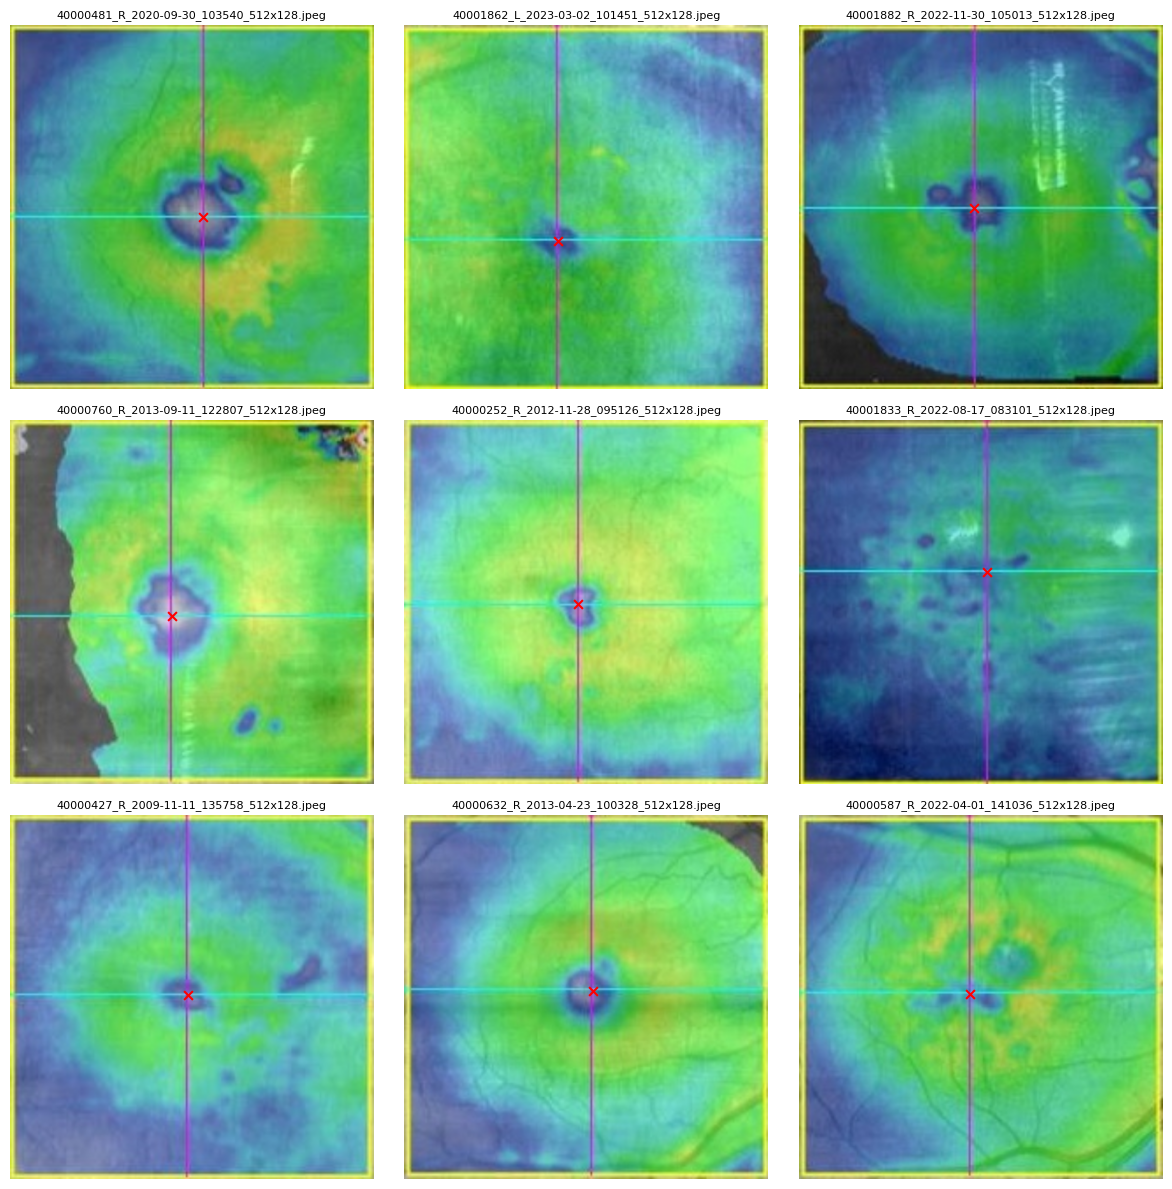

In [77]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import random

# === Config ===
csv_path = "fovea_manual_annotations.csv"  # Your saved annotations
etdrs_root = "ETDRS_cropped"               # Folder containing all ETDRS images
image_size = (512, 512)

# === Load CSV ===
df = pd.read_csv(csv_path)
df['filename'] = df['image_path'].apply(lambda x: os.path.basename(str(x)).strip("'").strip('"'))

# === Map filename to full path by scanning ETDRS_cropped ===
all_images = glob(os.path.join(etdrs_root, "**", "*.jpeg"), recursive=True)
path_map = {os.path.basename(p): p for p in all_images}
df['resolved_path'] = df['filename'].map(path_map)

# === Filter rows with found paths only ===
df_valid = df[df['resolved_path'].notnull()].copy()

# === Sample 9 rows for plotting ===
random.seed(42)
sample_df = df_valid.sample(n=min(9, len(df_valid)))

# === Plotting ===
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, (_, row) in enumerate(sample_df.iterrows()):
    path = row['resolved_path']
    img = cv2.imread(path)
    img = cv2.resize(img, image_size)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x, y = row['x_pixel'], row['y_pixel']

    axes[i].imshow(rgb)
    axes[i].scatter(x, y, s=40, c='red', marker='x')
    axes[i].set_title(os.path.basename(path), fontsize=8)
    axes[i].axis("off")

plt.tight_layout()
plt.show()


### Test train split.

In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# === Config ===
input_csv = "fovea_manual_annotations.csv"
output_csv = "fovea_all_coords.csv"
output_train_csv = "fovea_train.csv"
output_test_csv = "fovea_test.csv"

# === Load and Prepare Data ===
df = pd.read_csv(input_csv, header=None)
df.columns = ['image_path', 'x_pixel', 'y_pixel', 'dx_pixel', 'dy_pixel', 'dx_micron', 'dy_micron']

# Infer category from path
def get_category(path):
    parts = path.replace("\\", "/").split('/')
    for cat in ['early', 'int', 'GA']:
        if cat in parts:
            return cat
    return 'unknown'

df['category'] = df['image_path'].apply(get_category)
df['filename'] = df['image_path'].apply(lambda x: os.path.basename(x))

# Save full file
df.to_csv(output_csv, index=False)
print(f"✅ Saved all data to {output_csv}")

# Count per category
counts = df['category'].value_counts()
print("\nCategory counts:\n", counts)

# Check if stratified split is possible
if (counts < 2).any():
    print("⚠️ Not enough samples in at least one category. Performing random split without stratification.")
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
else:
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['category'])

# Save splits
train_df.to_csv(output_train_csv, index=False)
test_df.to_csv(output_test_csv, index=False)

print(f"\n✅ Split complete. Train: {len(train_df)}, Test: {len(test_df)}")
print("Train category distribution:\n", train_df['category'].value_counts())
print("Test category distribution:\n", test_df['category'].value_counts())


✅ Saved all data to fovea_all_coords.csv

Category counts:
 category
GA         29
early      29
int        28
unknown     1
Name: count, dtype: int64
⚠️ Not enough samples in at least one category. Performing random split without stratification.

✅ Split complete. Train: 69, Test: 18
Train category distribution:
 category
early    27
GA       23
int      19
Name: count, dtype: int64
Test category distribution:
 category
int        9
GA         6
early      2
unknown    1
Name: count, dtype: int64


### Train test split (EXCLUDE healthy)


In [95]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split

# # === Load Excel Data ===
# file_path = "ETDRS_Foveal_enfaces/30_pats_data_Foveal_Center.xlsx"
# df = pd.read_excel(file_path)
# print(f"Loaded {len(df)} rows from Excel.")

# # === Clean & Rename ===
# df.columns = [col.strip() for col in df.columns]
# df = df.rename(columns={
#     'Foveal_B-Scan': 'fovea_x',          # Right = +
#     'Foveal_A-Scan': 'fovea_y',          # UP = +
#     'patient_i#': 'patient_id',
#     'visit_dat': 'visit_date'
# })

# # === Drop unusable rows ===
# df = df.replace('repeat above', np.nan)
# df = df.dropna(subset=['fovea_x', 'fovea_y'])
# df['fovea_x'] = pd.to_numeric(df['fovea_x'], errors='coerce')
# df['fovea_y'] = pd.to_numeric(df['fovea_y'], errors='coerce')
# df['time'] = pd.to_numeric(df['time'], errors='coerce')
# df = df.dropna(subset=['fovea_x', 'fovea_y', 'time'])

# # === Pathological filter ===
# df['visit'] = df['visit'].str.strip().str.lower()
# df = df[df['visit'].isin(['first', 'last'])].copy()
# print(f"Pathological entries retained: {len(df)}")

# # === Clean strings ===
# for col in ['patient_id', 'laterality', 'visit_date']:
#     df[col] = df[col].astype(str).str.strip()

# # === Absolute coordinates from center ===
# IMAGE_SIZE = 512
# CENTER = IMAGE_SIZE // 2

# # Right/down offsets from center
# df['fovea_x'] = CENTER + df['fovea_x']  # B-scan → right of center
# df['fovea_y'] = CENTER - df['fovea_y']  # A-scan → upward offset

# # Clip just in case
# df['fovea_x'] = df['fovea_x'].clip(0, IMAGE_SIZE - 1)
# df['fovea_y'] = df['fovea_y'].clip(0, IMAGE_SIZE - 1)

# # === Split by patient ID ===
# train_ids, test_ids = train_test_split(df['patient_id'].unique(), test_size=0.2, random_state=42)
# train_df = df[df['patient_id'].isin(train_ids)].copy()
# test_df = df[df['patient_id'].isin(test_ids)].copy()

# # === Save ===
# train_df.to_csv("etdrs_fixation_train.csv", index=False)
# test_df.to_csv("etdrs_fixation_test.csv", index=False)

# print(f"Train: {len(train_df)}, Test: {len(test_df)}")
# print("Train visit counts:", train_df['visit'].value_counts().to_dict())
# print("Test  visit counts:", test_df['visit'].value_counts().to_dict())


# Load the Masks

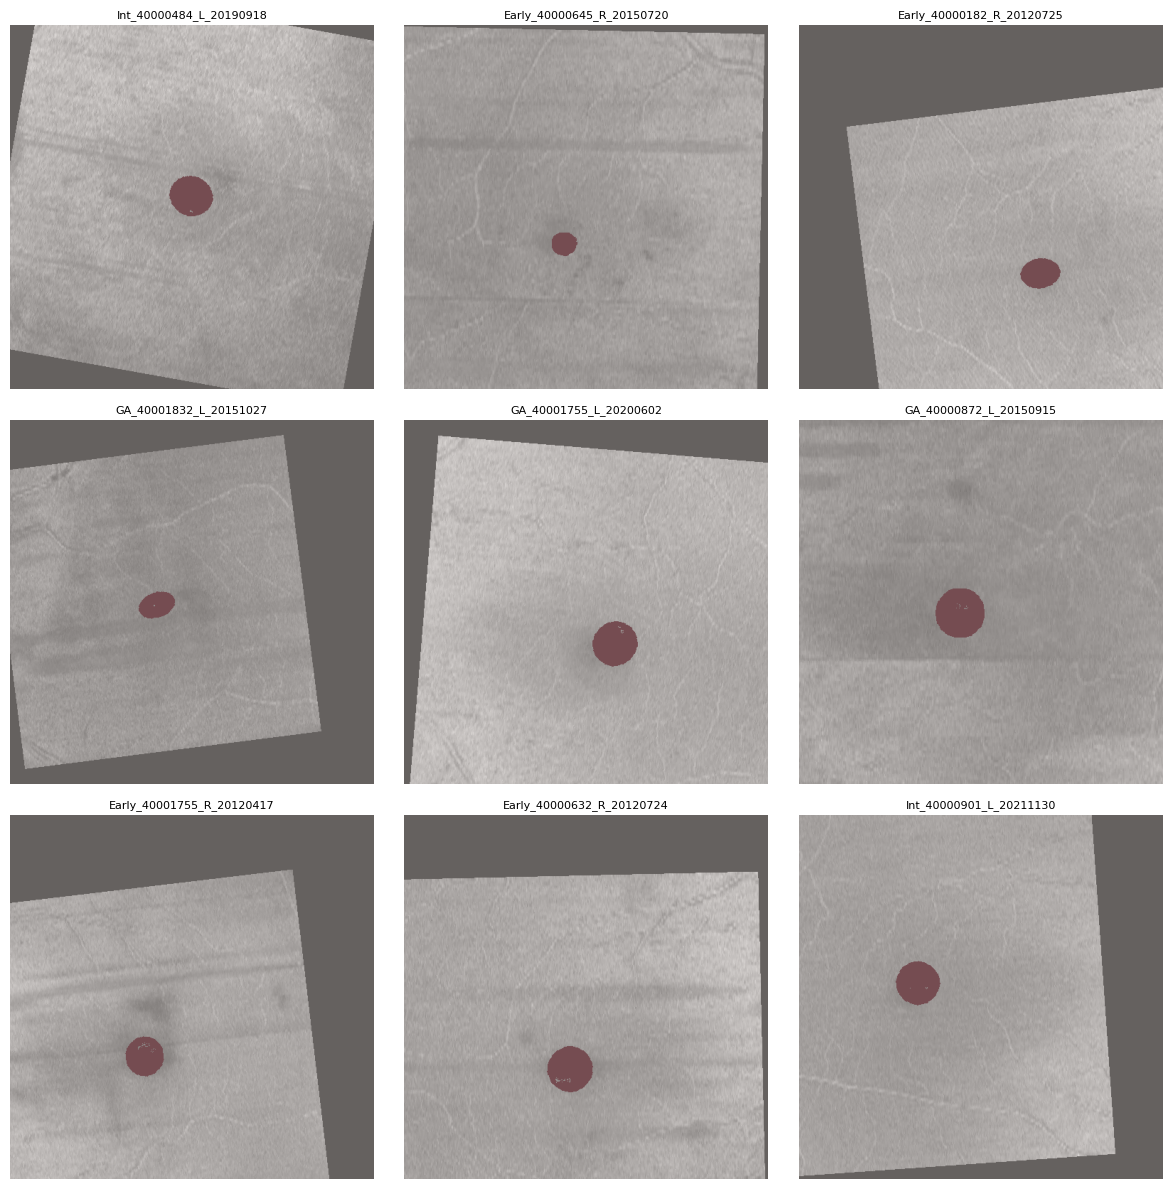

In [96]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Color thresholds for fovea mask detection
THRESH_COLORS = [
    (255, 215, 0),    # Gold — captures many solid masks without being too pale
    (255, 200, 0),    # Deep orange — original, safe and reliable
    (255, 255, 140),  # Pale yellow-white — for the highlighted center blobs
]
TOLERANCE = 55  # Tolerance for RGB variation

# =============== Dataset Loader ===============
class EnfaceMaskedDataset(Dataset):
    def __init__(self, root_dir, image_size=512):
        self.root_dir = root_dir
        self.image_size = image_size
        self.patients = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.augment = transforms.Compose([
            transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip()
        ])
        self.to_tensor = transforms.ToTensor()
        self.resize = transforms.Resize((image_size, image_size))

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient = self.patients[idx]
        enface_path = os.path.join(self.root_dir, patient, 'raw enface')
        mask_path = os.path.join(self.root_dir, patient, 'enface mask')

        enface_file = next(f for f in os.listdir(enface_path) if f.lower().endswith('.jpg'))
        mask_file = next(f for f in os.listdir(mask_path) if f.lower().endswith(('.png', '.jpg')))

        enface_img = Image.open(os.path.join(enface_path, enface_file)).convert('RGB')
        mask_img = Image.open(os.path.join(mask_path, mask_file)).convert('RGB')

        # Apply same random seed for synchronized augmentation
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        enface_img = self.augment(enface_img)
        random.seed(seed)
        torch.manual_seed(seed)
        mask_img = self.augment(mask_img)

        # Resize and convert
        enface_tensor = self.to_tensor(self.resize(enface_img)) * 2 - 1
        mask_np = np.array(self.resize(mask_img))
        mask_combined = np.zeros(mask_np.shape[:2], dtype=bool)

        for color in THRESH_COLORS:
            lower = np.array([max(0, c - TOLERANCE) for c in color])
            upper = np.array([min(255, c + TOLERANCE) for c in color])
            mask_bin = np.all((mask_np >= lower) & (mask_np <= upper), axis=-1)
            mask_combined |= mask_bin

        mask_tensor = torch.tensor(mask_combined.astype(np.float32))

        return enface_tensor, mask_tensor, patient

# =============== Visualize Random Transformed Samples ===============
def visualize_augmented_samples(dataset_path, num_samples=9):
    dataset = EnfaceMaskedDataset(dataset_path)
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(indices):
        img, mask, name = dataset[idx]
        masked_img = img.clone()
        for c in range(3):
            masked_img[c] *= (1 - mask)

        img_np = ((masked_img + 1) / 2).permute(1, 2, 0).numpy()
        mask_np = mask.numpy()

        plt.subplot(3, 3, i + 1)
        plt.imshow(img_np)
        plt.imshow(mask_np, cmap="Reds", alpha=0.4)
        plt.axis("off")
        plt.title(name, fontsize=8)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    visualize_augmented_samples("super_curated_enface")


# Mapping code (making sure ETDRS fixation point changes based on data augmentations)

In [97]:
import os
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from torchvision import transforms

# Constants
IMAGE_SIZE = 512
OUTPUT_DIR = "fixation_test_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Example fixation point coordinates
FIXATION_X = 150  # Change these to test different positions
FIXATION_Y = 250

# 1. Load a sample image
def load_test_image(image_path):
    """Load a test image (use any image from your dataset)"""
    try:
        # Try to load the specified image
        img = Image.open(image_path).convert('RGB')
        img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
        return img
    except:
        # If that fails, create a simple gradient image
        print(f"Creating a test image instead of loading from {image_path}")
        img = Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE), color=(240, 240, 240))
        draw = ImageDraw.Draw(img)
        # Add some visual elements to make transformations visible
        for i in range(0, IMAGE_SIZE, 50):
            draw.line([(i, 0), (i, IMAGE_SIZE)], fill=(200, 200, 200), width=1)
            draw.line([(0, i), (IMAGE_SIZE, i)], fill=(200, 200, 200), width=1)
        # Add some colored regions
        draw.rectangle([(100, 100), (200, 200)], fill=(230, 200, 200))
        draw.rectangle([(300, 300), (400, 400)], fill=(200, 230, 200))
        return img

# 2. Create transformations
def get_transformations():
    # Individual transforms so we can apply them one by one with the same seed
    resize = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
    affine = transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2))
    hflip = transforms.RandomHorizontalFlip(p=0.5)
    vflip = transforms.RandomVerticalFlip(p=0.5)
    to_tensor = transforms.ToTensor()
    
    return resize, affine, hflip, vflip, to_tensor

# 3. Function to track fixation point through transformations
def track_fixation_point(image, fixation_x, fixation_y, transforms_to_apply, use_circle=True):
    """
    Apply transformations to image and track the fixation point
    
    Args:
        image: PIL Image to transform
        fixation_x, fixation_y: Original fixation coordinates
        transforms_to_apply: List of transformations to apply
        use_circle: Whether to use a circle or single pixel 
        
    Returns:
        transformed_image: The transformed PIL image
        final_fixation: (x, y) coordinates of the transformed fixation point
    """
    # Clamp fixation point to image boundaries
    fx = max(0, min(int(fixation_x), IMAGE_SIZE-1))
    fy = max(0, min(int(fixation_y), IMAGE_SIZE-1))
    
    # Create a mask image with the fixation point
    if use_circle:
        # Create a circle for better tracking
        radius = 5
        fixation_img = Image.new('L', (IMAGE_SIZE, IMAGE_SIZE), 0)
        draw = ImageDraw.Draw(fixation_img)
        draw.ellipse((fx-radius, fy-radius, fx+radius, fy+radius), fill=255)
    else:
        # Create a single pixel
        fixation_img = Image.new('L', (IMAGE_SIZE, IMAGE_SIZE), 0)
        fixation_img.putpixel((fx, fy), 255)
    
    # Make a copy of the original image with the fixation point marked
    original_with_marker = image.copy()
    draw = ImageDraw.Draw(original_with_marker)
    draw.ellipse((fx-5, fy-5, fx+5, fy+5), outline=(255, 0, 0), width=2)
    
    # Set a random seed for transformations
    seed = np.random.randint(2147483647)
    
    # Apply each transformation with the same seed
    for transform in transforms_to_apply:
        if transform is not None:
            random.seed(seed)
            torch.manual_seed(seed)
            image = transform(image)
            
            random.seed(seed)
            torch.manual_seed(seed)
            fixation_img = transform(fixation_img)
    
    # Find the fixation point in the transformed image
    fixation_np = np.array(fixation_img).astype(float)
    if fixation_np.max() > 0:  # Check if any pixel is visible
        # Calculate weighted centroid of the transformed fixation point
        y_indices, x_indices = np.mgrid[:fixation_np.shape[0], :fixation_np.shape[1]]
        total_weight = fixation_np.sum()
        new_x = (x_indices * fixation_np).sum() / total_weight
        new_y = (y_indices * fixation_np).sum() / total_weight
        final_fixation = (new_x, new_y)
    else:
        print("Warning: Fixation point lost during transformation")
        final_fixation = (fx, fy)  # Default back to original
    
    return image, final_fixation, original_with_marker

# 4. Visualization function
def visualize_tracking(original_image, transformed_image, original_fixation, tracked_fixation, filename):
    """Create a visual comparison showing the fixation point tracking"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image with fixation
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image with Fixation Point")
    axes[0].axis('off')
    
    # Transformed image with tracked fixation
    axes[1].imshow(transformed_image)
    axes[1].scatter(tracked_fixation[0], tracked_fixation[1], c='red', s=100, marker='x')
    axes[1].set_title(f"Transformed Image with Tracked Fixation\n({tracked_fixation[0]:.1f}, {tracked_fixation[1]:.1f})")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, filename))
    plt.close()
    return fig

# 5. Main test function
def run_fixation_tracking_test(image_path="super_curated_enface/OCT_40000087_R_20130130_151832/raw enface/OCT_40000087_R_20130130_151832_enface.jpg"):
    """Run a complete test of fixation point tracking through transformations"""
    # Load test image
    image = load_test_image(image_path)
    
    # Get transformations
    resize, affine, hflip, vflip, to_tensor = get_transformations()
    
    # Test 1: Just affine transformation
    print("Test 1: Affine transformation")
    transformed, tracked_fixation, original_marked = track_fixation_point(
        image, FIXATION_X, FIXATION_Y, [affine], use_circle=True
    )
    visualize_tracking(original_marked, transformed, (FIXATION_X, FIXATION_Y), 
                       tracked_fixation, "test1_affine.png")
    
    # Test 2: Affine + Horizontal flip
    print("Test 2: Affine + Horizontal flip")
    transformed, tracked_fixation, original_marked = track_fixation_point(
        image, FIXATION_X, FIXATION_Y, [affine, hflip], use_circle=True
    )
    visualize_tracking(original_marked, transformed, (FIXATION_X, FIXATION_Y), 
                       tracked_fixation, "test2_affine_hflip.png")
    
    # Test 3: All transformations
    print("Test 3: All transformations")
    transformed, tracked_fixation, original_marked = track_fixation_point(
        image, FIXATION_X, FIXATION_Y, [affine, hflip, vflip], use_circle=True
    )
    visualize_tracking(original_marked, transformed, (FIXATION_X, FIXATION_Y), 
                       tracked_fixation, "test3_all_transforms.png")
    
    # Test 4: Compare circle vs. pixel methods
    print("Test 4: Circle vs. Pixel methods")
    # With circle
    transformed_circle, tracked_circle, original_marked = track_fixation_point(
        image, FIXATION_X, FIXATION_Y, [affine, hflip, vflip], use_circle=True
    )
    # With pixel
    transformed_pixel, tracked_pixel, _ = track_fixation_point(
        image, FIXATION_X, FIXATION_Y, [affine, hflip, vflip], use_circle=False
    )
    
    # Create comparison visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(original_marked)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(transformed_circle)
    axes[1].scatter(tracked_circle[0], tracked_circle[1], c='red', s=100, marker='x')
    axes[1].set_title(f"Circle Method: ({tracked_circle[0]:.1f}, {tracked_circle[1]:.1f})")
    axes[1].axis('off')
    
    axes[2].imshow(transformed_pixel)
    axes[2].scatter(tracked_pixel[0], tracked_pixel[1], c='blue', s=100, marker='x')
    axes[2].set_title(f"Pixel Method: ({tracked_pixel[0]:.1f}, {tracked_pixel[1]:.1f})")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "test4_comparison.png"))
    plt.close()
    
    print(f"Tests complete! Results saved to {OUTPUT_DIR}")
    return "Tests completed successfully"

# Run the test with a real image if available
# You can change this path to point to one of your actual images
run_fixation_tracking_test()

Creating a test image instead of loading from super_curated_enface/OCT_40000087_R_20130130_151832/raw enface/OCT_40000087_R_20130130_151832_enface.jpg
Test 1: Affine transformation
Test 2: Affine + Horizontal flip
Test 3: All transformations
Test 4: Circle vs. Pixel methods
Tests complete! Results saved to fixation_test_results


'Tests completed successfully'

# New Segmentation Model

In [108]:
# # =============== Imports ===============
# import os
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# from torchvision.utils import save_image
# from PIL import Image
# import numpy as np
# import random
# import matplotlib.pyplot as plt

# # =============== Constants ===============
# THRESH_COLORS = [(255, 200, 0), (255, 255, 0)]
# TOLERANCE = 60
# IMAGE_SIZE = 512
# PATCH_SIZE = 32
# CENTER = torch.tensor([IMAGE_SIZE // 2, IMAGE_SIZE // 2])

# # =============== Positional Embeddings ===============
# def get_2d_sincos_pos_embed(embed_dim, grid_size):
#     assert embed_dim % 2 == 0
#     grid_h = np.arange(grid_size, dtype=np.float32)
#     grid_w = np.arange(grid_size, dtype=np.float32)
#     emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid_h)
#     emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid_w)
#     emb = np.concatenate([
#         np.repeat(emb_h[:, None, :], grid_size, axis=1),
#         np.repeat(emb_w[None, :, :], grid_size, axis=0)
#     ], axis=-1)
#     return emb.reshape(-1, embed_dim)

# def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
#     assert embed_dim % 2 == 0
#     omega = np.arange(embed_dim // 2, dtype=np.float32)
#     omega /= embed_dim / 2.
#     omega = 1. / 10000**omega
#     pos = np.asarray(pos).reshape(-1)
#     out = np.outer(pos, omega)
#     return np.concatenate([np.sin(out), np.cos(out)], axis=1)

# # =============== Dataset ===============

# import pandas as pd
# from sklearn.model_selection import train_test_split
# from PIL import Image, ImageDraw


# def apply_affine_to_point(x, y, matrix):
#     """
#     Applies a 2D affine transformation matrix to a point (x, y).

#     Args:
#         x (float): X-coordinate of the point
#         y (float): Y-coordinate of the point
#         matrix (np.ndarray): 3x3 affine transformation matrix

#     Returns:
#         (float, float): Transformed coordinates
#     """
#     point = np.array([x, y, 1])
#     x_new, y_new, _ = matrix @ point
#     return float(x_new), float(y_new)

# import math

# def get_affine_matrix(degrees, translate, scale, img_size, seed=None):
#     """
#     Construct an affine transformation matrix using random parameters.
#     This mimics torchvision.transforms.RandomAffine behavior.

#     Returns:
#         matrix (np.ndarray): 3x3 affine transformation matrix
#         params (dict): parameters used (for reproducibility if needed)
#     """
#     if seed is not None:
#         random.seed(seed)
    
#     angle = random.uniform(-degrees, degrees)
#     max_dx = translate * img_size
#     max_dy = translate * img_size
#     translations = (random.uniform(-max_dx, max_dx), random.uniform(-max_dy, max_dy))
#     scale_factor = random.uniform(*scale)

#     theta = math.radians(angle)
#     alpha = scale_factor * math.cos(theta)
#     beta = scale_factor * math.sin(theta)

#     cx, cy = img_size / 2, img_size / 2

#     # PIL-style affine matrix (pixel coords): first row is for x', second is for y'
#     matrix = np.array([
#         [alpha, -beta, (1 - alpha) * cx + beta * cy + translations[0]],
#         [beta,  alpha, (1 - alpha) * cy - beta * cx + translations[1]],
#         [0,     0,     1]
#     ])

#     return matrix, {'angle': angle, 'translations': translations, 'scale': scale_factor}


# class EnfaceFixationAndSegmentationDataset(Dataset):
#     def __init__(self, csv_path, image_size=512, augment=True, generate_mask=True):
#         """
#         Dataset for both fixation point detection and segmentation, with option for synthetic masks.
        
#         Args:
#             csv_path: Path to CSV file with image paths and fixation points
#             image_size: Size to resize images to
#             augment: Whether to apply data augmentation
#             generate_mask: Whether to generate synthetic circular masks when real masks aren't found
#         """
#         self.image_size = image_size
#         self.augment = augment
#         self.generate_mask = generate_mask
        
#         # Load data with manual fixation points
#         self.df = pd.read_csv(csv_path)
#         print(f"Loaded {len(self.df)} entries from {csv_path}")
        
#         # Print a few sample entries to debug
#         print("Sample CSV entries:")
#         print(self.df.head(2))
        
#         # Image transformations
#         self.to_tensor = transforms.ToTensor()
#         self.resize = transforms.Resize((image_size, image_size))
        
#         # Validate data - check images
#         self.valid_entries = []
        
#         for idx, row in self.df.iterrows():
#             try:
#                 image_path = row['image_path']
                
#                 # Skip header rows that might be in the data
#                 if isinstance(image_path, str) and image_path == 'image_path':
#                     continue
                    
#                 # Check if image file exists
#                 if os.path.exists(image_path):
#                     try:
#                         x_pixel = float(row['x_pixel'])
#                         y_pixel = float(row['y_pixel'])
                        
#                         # Add to valid entries
#                         self.valid_entries.append({
#                             'image_path': image_path,
#                             'x_pixel': x_pixel,
#                             'y_pixel': y_pixel,
#                             'category': row.get('category', 'unknown')
#                         })
#                         print(f"Found valid image: {image_path}")
                        
#                     except Exception as e:
#                         print(f"Error processing fixation point for {image_path}: {e}")
#                 else:
#                     # Try extracting the filename and checking if it's in a relative path
#                     filename = os.path.basename(image_path)
#                     # Try to find the image anywhere in current working directory recursively
#                     found = False
#                     for root, dirs, files in os.walk('.'):
#                         if filename in files:
#                             full_path = os.path.join(root, filename)
#                             if os.path.exists(full_path):
#                                 try:
#                                     x_pixel = float(row['x_pixel'])
#                                     y_pixel = float(row['y_pixel'])
                                    
#                                     # Add to valid entries
#                                     self.valid_entries.append({
#                                         'image_path': full_path,
#                                         'x_pixel': x_pixel,
#                                         'y_pixel': y_pixel,
#                                         'category': row.get('category', 'unknown')
#                                     })
#                                     print(f"Found image at alternative path: {full_path}")
#                                     found = True
#                                     break
#                                 except Exception as e:
#                                     print(f"Error processing fixation point for {full_path}: {e}")
#                         if found:
#                             break
                            
#                     if not found:
#                         print(f"Warning: Image file not found - {image_path}")
#             except Exception as e:
#                 print(f"Error processing row {idx}: {e}")
        
#         print(f"Found {len(self.valid_entries)} valid entries with images and fixation points")
        
#         if len(self.valid_entries) == 0:
#             print("WARNING: No valid entries found! Please check paths and file structure.")
    
#     def generate_synthetic_mask(self, center_x, center_y, radius=40):
#         """Generate a circular synthetic mask centered on the fixation point"""
#         mask = np.zeros((self.image_size, self.image_size), dtype=np.float32)
#         y_indices, x_indices = np.ogrid[:self.image_size, :self.image_size]
#         dist_from_center = np.sqrt((x_indices - center_x)**2 + (y_indices - center_y)**2)
#         mask[dist_from_center <= radius] = 1.0
#         return torch.tensor(mask)
    
#     def __len__(self):
#         return len(self.valid_entries)
   
#     def __getitem__(self, idx):
#         entry = self.valid_entries[idx]
        
#         try:
#             # Load image
#             image = Image.open(entry['image_path']).convert('RGB')
            
#             # Original image dimensions
#             orig_width, orig_height = image.size
            
#             # Resize
#             image = self.resize(image)
            
#             # Scale fixation point to resized dimensions
#             scale_x = self.image_size / orig_width
#             scale_y = self.image_size / orig_height
            
#             fx = max(0, min(entry['x_pixel'] * scale_x, self.image_size - 1))
#             fy = max(0, min(entry['y_pixel'] * scale_y, self.image_size - 1))
            
#             # Generate synthetic mask centered on fixation point
#             mask_tensor = self.generate_synthetic_mask(fx, fy)
            
#             # Keep original fixation before augmentation
#             fixation = torch.tensor([fx, fy], dtype=torch.float32)
            
#             if self.augment:
#                 # === Apply augmentations ===
#                 seed = np.random.randint(2147483647)
#                 random.seed(seed)
#                 torch.manual_seed(seed)
                
#                 angle = random.uniform(-15, 15)
#                 translate = (random.uniform(-0.2, 0.2) * self.image_size,
#                             random.uniform(-0.2, 0.2) * self.image_size)
#                 scale = random.uniform(0.8, 1.2)
#                 shear = [0.0, 0.0]
                
#                 theta = math.radians(angle)
#                 alpha = scale * math.cos(theta)
#                 beta = scale * math.sin(theta)
#                 cx = cy = self.image_size / 2
#                 tx, ty = translate
#                 affine_matrix = np.array([
#                     [alpha, -beta, (1 - alpha) * cx + beta * cy + tx],
#                     [beta,  alpha, (1 - alpha) * cy - beta * cx + ty],
#                     [0, 0, 1]
#                 ])
                
#                 import torchvision.transforms.functional as TF
#                 image = TF.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
                
#                 # Transform mask
#                 mask_img = transforms.ToPILImage()(mask_tensor)
#                 mask_img = TF.affine(mask_img, angle=angle, translate=translate, scale=scale, shear=shear)
#                 mask_tensor = self.to_tensor(mask_img).squeeze()
                
#                 # Apply affine to fixation point
#                 new_fx, new_fy = apply_affine_to_point(fx, fy, affine_matrix)
#                 new_fx = max(0, min(new_fx, self.image_size - 1))
#                 new_fy = max(0, min(new_fy, self.image_size - 1))
#                 fixation = torch.tensor([float(new_fx), float(new_fy)], dtype=torch.float32)
                
#                 # Horizontal/Vertical Flips
#                 if random.random() < 0.5:
#                     image = TF.hflip(image)
#                     mask_tensor = TF.hflip(transforms.ToPILImage()(mask_tensor))
#                     mask_tensor = self.to_tensor(mask_tensor).squeeze()
#                     fixation[0] = self.image_size - 1 - fixation[0]
                
#                 if random.random() < 0.5:
#                     image = TF.vflip(image)
#                     mask_tensor = TF.vflip(transforms.ToPILImage()(mask_tensor))
#                     mask_tensor = self.to_tensor(mask_tensor).squeeze()
#                     fixation[1] = self.image_size - 1 - fixation[1]
            
#             # Convert to tensor
#             image_tensor = self.to_tensor(image) * 2 - 1
            
#             # Calculate fixation offset from center
#             center = torch.tensor([self.image_size // 2, self.image_size // 2], dtype=torch.float32)
#             fixation_offset = fixation - center
            
#             return image_tensor, mask_tensor, fixation_offset
            
#         except Exception as e:
#             print(f"Error loading data for index {idx}: {e}")
#             return torch.zeros(3, self.image_size, self.image_size), torch.zeros(self.image_size, self.image_size), torch.zeros(2)

# class EnfaceSegmentationWithFixationDataset(Dataset):
#     def __init__(self, csv_path, image_size=512, augment=True):
#         """
#         Dataset for both segmentation and fixation point detection
        
#         Args:
#             csv_path: Path to CSV file with image paths and fixation points
#             image_size: Size to resize images to
#             augment: Whether to apply data augmentation
#         """
#         self.image_size = image_size
#         self.augment = augment
        
#         # Load data with manual fixation points
#         self.df = pd.read_csv(csv_path)
#         print(f"Loaded {len(self.df)} entries from {csv_path}")
        
#         # Print a few sample entries to debug
#         print("Sample CSV entries:")
#         print(self.df.head(2))
        
#         # Image transformations
#         self.to_tensor = transforms.ToTensor()
#         self.resize = transforms.Resize((image_size, image_size))
        
#         # Validate data - check images
#         self.valid_entries = []
        
#         for idx, row in self.df.iterrows():
#             # Skip header rows
#             if isinstance(row.get('image_path'), str) and row['image_path'] == 'image_path':
#                 continue
                
#             image_path = row['image_path']
            
#             # Check if image file exists
#             if os.path.exists(image_path):
#                 try:
#                     # Get absolute pixel coordinates directly from CSV
#                     x_pixel = float(row['x_pixel'])
#                     y_pixel = float(row['y_pixel'])
                    
#                     # Add to valid entries if all checks pass
#                     self.valid_entries.append({
#                         'image_path': image_path,
#                         'x_pixel': x_pixel,
#                         'y_pixel': y_pixel,
#                         'category': row.get('category', 'unknown')
#                     })
                    
#                 except Exception as e:
#                     print(f"Error processing fixation point for {image_path}: {e}")
#             else:
#                 print(f"Warning: Image file not found - {image_path}")
        
#         print(f"Found {len(self.valid_entries)} valid entries with images and fixation points")
        
#         if len(self.valid_entries) == 0:
#             print("WARNING: No valid entries found! Please check paths and file structure.")
    
#     def generate_synthetic_mask(self, center_x, center_y, radius=40):
#         """Generate a circular synthetic mask centered on the fixation point"""
#         mask = np.zeros((self.image_size, self.image_size), dtype=np.float32)
#         y_indices, x_indices = np.ogrid[:self.image_size, :self.image_size]
#         dist_from_center = np.sqrt((x_indices - center_x)**2 + (y_indices - center_y)**2)
#         mask[dist_from_center <= radius] = 1.0
#         return torch.tensor(mask)
    
#     def __len__(self):
#         return len(self.valid_entries)
   
#     def __getitem__(self, idx):
#         entry = self.valid_entries[idx]
        
#         try:
#             # Load image
#             image = Image.open(entry['image_path']).convert('RGB')
            
#             # Original image dimensions
#             orig_width, orig_height = image.size
            
#             # Resize
#             image = self.resize(image)
            
#             # Scale fixation point to resized dimensions
#             scale_x = self.image_size / orig_width
#             scale_y = self.image_size / orig_height
            
#             # Convert original absolute pixel coordinates to coordinates in the resized image
#             fx = max(0, min(entry['x_pixel'] * scale_x, self.image_size - 1))
#             fy = max(0, min(entry['y_pixel'] * scale_y, self.image_size - 1))
            
#             # Generate a synthetic segmentation mask centered on the fixation point
#             mask_tensor = self.generate_synthetic_mask(fx, fy)
            
#             # Keep original fixation before augmentation
#             fixation = torch.tensor([fx, fy], dtype=torch.float32)
            
#             if self.augment:
#                 # === Apply same affine to all with tracked matrix ===
#                 seed = np.random.randint(2147483647)
#                 random.seed(seed)
#                 torch.manual_seed(seed)
                
#                 angle = random.uniform(-15, 15)
#                 translate = (random.uniform(-0.2, 0.2) * self.image_size,
#                             random.uniform(-0.2, 0.2) * self.image_size)
#                 scale = random.uniform(0.8, 1.2)
#                 shear = [0.0, 0.0]
                
#                 theta = math.radians(angle)
#                 alpha = scale * math.cos(theta)
#                 beta = scale * math.sin(theta)
#                 cx = cy = self.image_size / 2
#                 tx, ty = translate
#                 affine_matrix = np.array([
#                     [alpha, -beta, (1 - alpha) * cx + beta * cy + tx],
#                     [beta,  alpha, (1 - alpha) * cy - beta * cx + ty],
#                     [0, 0, 1]
#                 ])
                
#                 import torchvision.transforms.functional as TF
#                 image = TF.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
                
#                 # Transform mask
#                 mask_img = transforms.ToPILImage()(mask_tensor)
#                 mask_img = TF.affine(mask_img, angle=angle, translate=translate, scale=scale, shear=shear)
#                 mask_tensor = self.to_tensor(mask_img).squeeze()
                
#                 # Apply affine to fixation point
#                 new_fx, new_fy = apply_affine_to_point(fx, fy, affine_matrix)
#                 new_fx = max(0, min(new_fx, self.image_size - 1))
#                 new_fy = max(0, min(new_fy, self.image_size - 1))
#                 fixation = torch.tensor([float(new_fx), float(new_fy)], dtype=torch.float32)
                
#                 # Horizontal/Vertical Flips
#                 if random.random() < 0.5:
#                     image = TF.hflip(image)
#                     mask_img = transforms.ToPILImage()(mask_tensor)
#                     mask_img = TF.hflip(mask_img)
#                     mask_tensor = self.to_tensor(mask_img).squeeze()
#                     fixation[0] = self.image_size - 1 - fixation[0]
                
#                 if random.random() < 0.5:
#                     image = TF.vflip(image)
#                     mask_img = transforms.ToPILImage()(mask_tensor)
#                     mask_img = TF.vflip(mask_img)
#                     mask_tensor = self.to_tensor(mask_img).squeeze()
#                     fixation[1] = self.image_size - 1 - fixation[1]
            
#             # Convert to tensor
#             image_tensor = self.to_tensor(image) * 2 - 1  # Normalize to [-1, 1]
            
#             # Calculate fixation offset from center AFTER all transformations
#             center = torch.tensor([self.image_size // 2, self.image_size // 2], dtype=torch.float32)
#             fixation_offset = fixation - center
            
#             return image_tensor, mask_tensor, fixation_offset, fixation  # Return both offset and absolute position
            
#         except Exception as e:
#             print(f"Error loading data for index {idx}: {e}")
#             return torch.zeros(3, self.image_size, self.image_size), torch.zeros(self.image_size, self.image_size), torch.zeros(2), torch.zeros(2)

# #### maybe delete above classes(2)?????

# class EnfaceSegmentationWithFixationDataset(Dataset):
#     def __init__(self, root_dir, csv_path, image_size=512):
#         self.root_dir = root_dir
#         self.image_size = image_size
        
#         # Load data with manual fixation points
#         self.df = pd.read_csv(csv_path)
#         print(f"Loaded {len(self.df)} entries from {csv_path}")
        
#         # Print a few sample entries to debug
#         print("Sample CSV entries:")
#         print(self.df.head(2))
        
#         # Image transformations
#         self.to_tensor = transforms.ToTensor()
#         self.resize = transforms.Resize((image_size, image_size))
        
#         # Validate data - check that all image files exist
#         self.valid_entries = []
        
#         for idx, row in self.df.iterrows():
#             image_path = row['image_path']
            
#             # Check if it's a relative or absolute path
#             if not os.path.isabs(image_path):
#                 image_path = os.path.join(root_dir, image_path)
                
#             # Get directory for image
#             image_dir = os.path.dirname(image_path)
            
#             # Standardize image path handling
#             if os.path.exists(image_path):
#                 # Direct path exists
#                 enface_path = image_path
#             else:
#                 # Try to find the image by basename
#                 basename = os.path.basename(image_path)
                
#                 # Look in potential parent directories
#                 potential_dirs = [
#                     root_dir,
#                     os.path.join(root_dir, 'raw enface'),
#                     os.path.join(root_dir, 'enface'),
#                     os.path.join(root_dir, 'raw')
#                 ]
                
#                 # Also check if the path might be to a directory rather than a file
#                 if os.path.isdir(image_dir):
#                     potential_dirs.append(image_dir)
#                     potential_dirs.append(os.path.join(image_dir, 'raw enface'))
#                     potential_dirs.append(os.path.join(image_dir, 'enface'))
#                     potential_dirs.append(os.path.join(image_dir, 'raw'))
                
#                 found = False
#                 for dir_path in potential_dirs:
#                     if os.path.exists(dir_path):
#                         test_path = os.path.join(dir_path, basename)
#                         if os.path.exists(test_path):
#                             enface_path = test_path
#                             found = True
#                             break
                
#                 if not found:
#                     print(f"Warning: Could not find image file for {image_path}")
#                     continue
            
#             # Find corresponding mask
#             mask_path = None
            
#             # Try standard mask locations
#             image_dir = os.path.dirname(enface_path)
#             parent_dir = os.path.dirname(image_dir)
#             basename = os.path.basename(enface_path)
            
#             # Check possible mask directories
#             possible_mask_dirs = [
#                 os.path.join(parent_dir, 'enface mask'),
#                 os.path.join(parent_dir, 'mask'),
#                 os.path.join(parent_dir, 'segmentation'),
#                 os.path.join(image_dir, '..', 'enface mask'),
#                 os.path.join(image_dir, '..', 'mask'),
#                 os.path.join(image_dir, '..', 'segmentation')
#             ]
            
#             for mask_dir in possible_mask_dirs:
#                 if os.path.exists(mask_dir):
#                     # Try exact filename match first
#                     potential_mask = os.path.join(mask_dir, basename)
#                     if os.path.exists(potential_mask):
#                         mask_path = potential_mask
#                         break
                    
#                     # Try finding any image file
#                     mask_files = [f for f in os.listdir(mask_dir) 
#                                 if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))]
#                     if mask_files:
#                         mask_path = os.path.join(mask_dir, mask_files[0])
#                         break
            
#             if mask_path is None:
#                 print(f"Warning: Could not find mask for {enface_path}")
#                 continue
                
#             # Get fixation points
#             try:
#                 x_pixel = float(row['x_pixel'])
#                 y_pixel = float(row['y_pixel'])
                
#                 # Add to valid entries if all checks pass
#                 self.valid_entries.append({
#                     'enface_path': enface_path,
#                     'mask_path': mask_path, 
#                     'x_pixel': x_pixel,
#                     'y_pixel': y_pixel,
#                     'category': row.get('category', 'unknown')
#                 })
                
#             except Exception as e:
#                 print(f"Error processing fixation point for {enface_path}: {e}")
#                 continue
        
#         print(f"Found {len(self.valid_entries)} valid entries with images and fixation points")
        
#         if len(self.valid_entries) == 0:
#             print("WARNING: No valid entries found! Please check paths and file structure.")
    
#     def __len__(self):
#         return len(self.valid_entries)
   
#     def __getitem__(self, idx):
#         entry = self.valid_entries[idx]
        
#         try:
#             # Load images
#             enface_img = Image.open(entry['enface_path']).convert('RGB')
#             mask_img = Image.open(entry['mask_path']).convert('RGB')
            
#             # Original image dimensions
#             orig_width, orig_height = enface_img.size
            
#             # Resize
#             enface_img = self.resize(enface_img)
#             mask_img = self.resize(mask_img)
            
#             # Scale fixation point to resized dimensions
#             scale_x = self.image_size / orig_width
#             scale_y = self.image_size / orig_height
            
#             fx = max(0, min(entry['x_pixel'] * scale_x, self.image_size - 1))
#             fy = max(0, min(entry['y_pixel'] * scale_y, self.image_size - 1))
            
#             # Keep original fixation before augmentation
#             fixation = torch.tensor([fx, fy], dtype=torch.float32)
            
#             # === Apply same affine to all with tracked matrix ===
#             seed = np.random.randint(2147483647)
#             random.seed(seed)
#             torch.manual_seed(seed)
            
#             angle = random.uniform(-15, 15)
#             translate = (random.uniform(-0.2, 0.2) * self.image_size,
#                         random.uniform(-0.2, 0.2) * self.image_size)
#             scale = random.uniform(0.8, 1.2)
#             shear = [0.0, 0.0]
            
#             theta = math.radians(angle)
#             alpha = scale * math.cos(theta)
#             beta = scale * math.sin(theta)
#             cx = cy = self.image_size / 2
#             tx, ty = translate
#             affine_matrix = np.array([
#                 [alpha, -beta, (1 - alpha) * cx + beta * cy + tx],
#                 [beta,  alpha, (1 - alpha) * cy - beta * cx + ty],
#                 [0, 0, 1]
#             ])
            
#             import torchvision.transforms.functional as TF
#             enface_img = TF.affine(enface_img, angle=angle, translate=translate, scale=scale, shear=shear)
#             mask_img = TF.affine(mask_img, angle=angle, translate=translate, scale=scale, shear=shear)
            
#             # Apply affine to fixation point
#             new_fx, new_fy = apply_affine_to_point(fx, fy, affine_matrix)
#             new_fx = max(0, min(new_fx, self.image_size - 1))
#             new_fy = max(0, min(new_fy, self.image_size - 1))
#             fixation = torch.tensor([float(new_fx), float(new_fy)], dtype=torch.float32)
            
#             # === Horizontal/Vertical Flips ===
#             if random.random() < 0.5:
#                 enface_img = TF.hflip(enface_img)
#                 mask_img = TF.hflip(mask_img)
#                 fixation[0] = self.image_size - 1 - fixation[0]
            
#             if random.random() < 0.5:
#                 enface_img = TF.vflip(enface_img)
#                 mask_img = TF.vflip(mask_img)
#                 fixation[1] = self.image_size - 1 - fixation[1]
            
#             # Convert to tensors
#             enface_tensor = self.to_tensor(enface_img) * 2 - 1
#             mask_np = np.array(mask_img)
            
#             # Color thresholding for binary mask
#             mask_combined = np.zeros(mask_np.shape[:2], dtype=bool)
#             for color in THRESH_COLORS:
#                 lower = np.array([max(0, c - TOLERANCE) for c in color])
#                 upper = np.array([min(255, c + TOLERANCE) for c in color])
#                 mask_bin = np.all((mask_np >= lower) & (mask_np <= upper), axis=-1)
#                 mask_combined |= mask_bin
            
#             mask_tensor = torch.tensor(mask_combined.astype(np.float32))
            
#             # Calculate fixation offset from center AFTER all transformations
#             center = torch.tensor([self.image_size // 2, self.image_size // 2], dtype=torch.float32)
#             fixation_offset = fixation - center
            
#             return enface_tensor, mask_tensor, fixation_offset
            
#         except Exception as e:
#             print(f"Error loading data for index {idx}: {e}")
#             return torch.zeros(3, self.image_size, self.image_size), torch.zeros(self.image_size, self.image_size), torch.zeros(2)
        

# # =============== Loss ===============
# def fixation_loss(pred_offsets, true_offsets, pred_masks=None, radius_thresh=15, outside_penalty=0.0):
#     """
#     Compute loss for fixation point prediction with optional outside mask penalty
    
#     Args:
#         pred_offsets: Predicted fixation point offsets from center [B, 2]
#         true_offsets: Ground truth fixation offsets [B, 2]
#         pred_masks: Predicted segmentation masks [B, H, W]
#         radius_thresh: Threshold distance for acceptable error
#         outside_penalty: Weight for penalizing points outside mask (0.0 disables this)
        
#     Returns:
#         Combined fixation loss
#     """
#     # Ensure inputs are float for reliable loss calculation
#     pred_offsets = pred_offsets.float()
#     true_offsets = true_offsets.float()
    
#     # Distance component - using smooth L1 loss
#     distance_loss = F.smooth_l1_loss(pred_offsets, true_offsets)
    
#     # Optional inside mask component
#     outside_mask_loss = 0.0
#     if pred_masks is not None and outside_penalty > 0:
#         B = pred_masks.shape[0]
#         H, W = pred_masks.shape[1], pred_masks.shape[2]
        
#         # Calculate image coordinates of predicted fixation point
#         center = torch.tensor([W/2, H/2], device=pred_offsets.device, dtype=torch.float32)
#         pred_points = center.unsqueeze(0) + pred_offsets
        
#         # Clamp to image boundaries
#         x = pred_points[:, 0].clamp(0, W-1).long()
#         y = pred_points[:, 1].clamp(0, H-1).long()
        
#         # Check if predicted points are inside the segmentation mask
#         in_mask = torch.zeros(B, device=pred_masks.device, dtype=torch.float32)
#         for i in range(B):
#             in_mask[i] = pred_masks[i, y[i], x[i]].float()  # Convert to float
        
#         # Apply penalty for points outside mask
#         outside_mask_loss = outside_penalty * (1.0 - in_mask).mean()
    
#     return distance_loss + outside_mask_loss  


# def combined_loss(seg_pred, seg_gt, fix_pred, fix_gt, area_weight=0.2, empty_weight=1.0, outside_penalty=0.0, max_area=5625):
#     bce = F.binary_cross_entropy_with_logits(seg_pred, seg_gt.unsqueeze(1))
#     pred = torch.sigmoid(seg_pred)
    
#     # Dice loss
#     dice = 1 - (2 * (pred * seg_gt.unsqueeze(1)).sum() + 1e-6) / ((pred + seg_gt.unsqueeze(1)).sum() + 1e-6)
    
#     # Area constraint loss - convert to float before mean
#     # Original error line:
#     # area = F.relu((pred > 0.5).sum(dim=[2, 3]) - max_area).mean() / max_area
    
#     # Fixed version:
#     area_sum = (pred > 0.5).sum(dim=[2, 3]).float()  # Convert to float
#     area = F.relu(area_sum - max_area).mean() / max_area
    
#     # Empty prediction penalty - convert to float before mean
#     # Original: 
#     # empty = ((pred > 0.5).sum(dim=[2, 3]) == 0).float().mean() * empty_weight
    
#     # Fixed version (already has float conversion, but let's be explicit):
#     empty = ((pred > 0.5).sum(dim=[2, 3]) == 0).float().mean() * empty_weight
    
#     # Fixation loss
#     fix = fixation_loss(fix_pred, fix_gt, (pred > 0.5).squeeze(1), outside_penalty=outside_penalty)
    
#     # Combined loss
#     total = 0.4 * bce + dice + area_weight * area + empty + fix
#     return total, {'bce': bce.item(), 'dice': dice.item(), 'area': area.item(), 'empty': empty.item(), 'fix': fix.item()}


# # =============== Model ===============
# class MAESegmentationWithFixation(nn.Module):
#     def __init__(self, encoder, decoder, encoder_dim):
#         super().__init__()
#         self.encoder = encoder
#         self.decoder = decoder
#         self.fix_head = nn.Sequential(
#             nn.Linear(encoder_dim, encoder_dim // 2),
#             nn.ReLU(),
#             nn.Linear(encoder_dim // 2, 2)
#         )

#     def forward(self, x):
#         encoded_tokens, intermediates = self.encoder(x, return_intermediates=True)
#         segmentation = self.decoder(encoded_tokens, intermediates)
#         fix_offset = self.fix_head(encoded_tokens.mean(dim=1))
#         return segmentation, fix_offset

# # Import UNetPPDecoder if it's in another file
# # from your_decoder_module import UNetPPDecoder

# # OR define it inline here:
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, mid_channels=None):
#         super().__init__()
#         if mid_channels is None:
#             mid_channels = out_channels
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(mid_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
#     def forward(self, x):
#         return self.double_conv(x)

# class UpBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, skip_channels=0):
#         super().__init__()
#         self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
#         self.conv = ConvBlock(in_channels // 2 + skip_channels, out_channels)
#     def forward(self, x1, x2=None):
#         x1 = self.up(x1)
#         if x2 is not None:
#             diffY = x2.size()[2] - x1.size()[2]
#             diffX = x2.size()[3] - x1.size()[3]
#             x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
#             x = torch.cat([x2, x1], dim=1)
#         else:
#             x = x1
#         return self.conv(x)
    

# class UNetPPDecoder(nn.Module):
#     def __init__(self, encoder_dim=768, grid_size=16):
#         super().__init__()
#         self.grid_size = grid_size
#         self.encoder_dim = encoder_dim

#         self.conv_x00 = ConvBlock(encoder_dim, 512)
#         self.up_x01 = UpBlock(512, 256)
#         self.conv_x10 = ConvBlock(encoder_dim, 256)
#         self.conv_x11 = ConvBlock(512, 256)

#         self.up_x02 = UpBlock(256, 128)
#         self.up_x12 = UpBlock(256, 128)
#         self.conv_x20 = ConvBlock(encoder_dim, 128)
#         self.conv_x22 = ConvBlock(384, 128)

#         self.up_x03 = UpBlock(128, 64)
#         self.up_x13 = UpBlock(128, 64)
#         self.up_x23 = UpBlock(128, 64)
#         self.conv_x30 = ConvBlock(encoder_dim, 64)
#         self.conv_x33 = ConvBlock(256, 64)

#         self.up_x04 = UpBlock(64, 32)
#         self.up_x14 = UpBlock(64, 32)
#         self.up_x24 = UpBlock(64, 32)
#         self.up_x34 = UpBlock(64, 32)
#         self.conv_x40 = ConvBlock(encoder_dim, 32)
#         self.conv_x44 = ConvBlock(160, 32)

#         self.final = nn.Sequential(
#             nn.Conv2d(32, 16, kernel_size=3, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(16, 1, kernel_size=1)
#         )

#     def forward(self, encoded_features, intermediates):
#         B = encoded_features.shape[0]
#         x00 = encoded_features.permute(0, 2, 1).reshape(B, self.encoder_dim, self.grid_size, self.grid_size)
#         x00 = self.conv_x00(x00)

#         x10 = F.interpolate(intermediates[3].permute(0, 2, 1).reshape(B, self.encoder_dim, self.grid_size, self.grid_size),
#                             scale_factor=2, mode='bilinear')
#         x10 = self.conv_x10(x10)

#         x01 = self.up_x01(x00)
#         x11 = self.conv_x11(torch.cat([x10, x01], dim=1))

#         x20 = F.interpolate(intermediates[2].permute(0, 2, 1).reshape(B, self.encoder_dim, self.grid_size, self.grid_size),
#                             scale_factor=4, mode='bilinear')
#         x20 = self.conv_x20(x20)
#         x02 = self.up_x02(x01)
#         x12 = self.up_x12(x11)
#         x22 = self.conv_x22(torch.cat([x20, x02, x12], dim=1))

#         x30 = F.interpolate(intermediates[1].permute(0, 2, 1).reshape(B, self.encoder_dim, self.grid_size, self.grid_size),
#                             scale_factor=8, mode='bilinear')
#         x30 = self.conv_x30(x30)
#         x03 = self.up_x03(x02)
#         x13 = self.up_x13(x12)
#         x23 = self.up_x23(x22)
#         x33 = self.conv_x33(torch.cat([x30, x03, x13, x23], dim=1))

#         x40 = F.interpolate(intermediates[0].permute(0, 2, 1).reshape(B, self.encoder_dim, self.grid_size, self.grid_size),
#                             scale_factor=16, mode='bilinear')
#         x40 = self.conv_x40(x40)
#         x04 = self.up_x04(x03)
#         x14 = self.up_x14(x13)
#         x24 = self.up_x24(x23)
#         x34 = self.up_x34(x33)
#         x44 = self.conv_x44(torch.cat([x40, x04, x14, x24, x34], dim=1))

#         final = F.interpolate(x44, scale_factor=2, mode='bilinear', align_corners=True)
#         return self.final(final)

# class Block(nn.Module):
#     def __init__(self, dim, num_heads, grid_size, mlp_ratio=4., norm_layer=nn.LayerNorm):
#         super().__init__()
#         self.norm1 = norm_layer(dim)
#         self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
#         self.norm2 = norm_layer(dim)
#         self.mlp = nn.Sequential(
#             nn.Linear(dim, int(dim * mlp_ratio)),
#             nn.GELU(),
#             nn.Linear(int(dim * mlp_ratio), dim)
#         )

#     def forward(self, x):
#         x_res = x
#         x = self.norm1(x)
#         x, _ = self.attn(x, x, x)
#         x = x + x_res

#         x_res = x
#         x = self.norm2(x)
#         x = self.mlp(x)
#         x = x + x_res
#         return x


# class MAEEncoder(nn.Module):
#     """MAE Encoder with relative positional embeddings"""
#     def __init__(
#         self,
#         img_size=512,
#         patch_size=32,
#         in_chans=3,
#         embed_dim=768,
#         depth=8,
#         num_heads=12,
#         mlp_ratio=4.,
#         norm_layer=nn.LayerNorm,
#     ):
#         super().__init__()
#         # Encoder parameters
#         self.patch_size = patch_size
#         self.in_chans = in_chans
#         self.embed_dim = embed_dim
#         self.num_heads = num_heads
        
#         # Size info
#         self.img_size = img_size
#         self.patch_embed = nn.Conv2d(
#             in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
#         )
#         self.grid_size = img_size // patch_size
#         self.num_patches = self.grid_size ** 2
        
#         # Encoder embeddings
#         self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
#         self.pos_embed = nn.Parameter(
#             torch.zeros(1, 1 + self.num_patches, embed_dim),
#             requires_grad=False
#         )  # fixed sin-cos embedding

#         # Encoder blocks with intermediate outputs for skip connections
#         self.blocks = nn.ModuleList([
#             Block(
#                 embed_dim, 
#                 num_heads, 
#                 self.grid_size, 
#                 mlp_ratio=mlp_ratio, 
#                 norm_layer=norm_layer
#             )
#             for _ in range(depth)
#         ])
        
#         self.norm = norm_layer(embed_dim)
        
#         # Initialize weights
#         self._initialize_weights()

#     def _initialize_weights(self):
#         # Initialize cls_token
#         nn.init.normal_(self.cls_token, std=0.02)
        
#         # Initialize positional embedding
#         pos_embed = get_2d_sincos_pos_embed(self.embed_dim, self.grid_size)
#         pos_embed = torch.from_numpy(pos_embed).float().unsqueeze(0)
#         pe_token = torch.zeros(1, 1, self.embed_dim)
#         self.pos_embed.data.copy_(torch.cat([pe_token, pos_embed], dim=1))
        
#         # Initialize linear layers
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)
#             elif isinstance(m, nn.LayerNorm):
#                 nn.init.ones_(m.weight)
#                 nn.init.zeros_(m.bias)

#     def forward(self, x, return_intermediates=False):
#         """
#         Forward pass with option to return intermediate features for skip connections
#         """
#         # Convert image to patches
#         x = self.patch_embed(x)  # [B, C, H/P, W/P]
#         x = x.flatten(2).transpose(1, 2)  # [B, N, C]
        
#         # Add positional embedding (without cls token)
#         x = x + self.pos_embed[:, 1:, :]
        
#         # Append cls token
#         cls_token = self.cls_token + self.pos_embed[:, :1, :]
#         cls_tokens = cls_token.expand(x.shape[0], -1, -1)
#         x = torch.cat((cls_tokens, x), dim=1)
        
#         # Apply transformer blocks and collect intermediate features
#         intermediates = []
#         for blk in self.blocks:
#             x = blk(x)
#             if return_intermediates:
#                 intermediates.append(x[:, 1:].clone())  # Skip cls token
        
#         # Apply final normalization
#         x = self.norm(x)
        
#         # Return features after cls token
#         if return_intermediates:
#             return x[:, 1:], intermediates  # Return without cls token
#         else:
#             return x[:, 1:]  # Return without cls token

# # =============== UNet++ Decoder with Skip Connections ===============
# class ConvBlock(nn.Module):
#     """Double convolution block for UNet++"""
#     def __init__(self, in_channels, out_channels, mid_channels=None):
#         super().__init__()
#         if mid_channels is None:
#             mid_channels = out_channels
            
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(mid_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
    
#     def forward(self, x):
#         return self.double_conv(x)

# class UpBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, skip_channels=0, bilinear=False):
#         super().__init__()
#         if bilinear:
#             self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#             up_channels = in_channels
#         else:
#             self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
#             up_channels = in_channels // 2

#         self.conv = ConvBlock(up_channels + skip_channels, out_channels)

#     def forward(self, x1, x2=None):
#         x1 = self.up(x1)
#         if x2 is not None:
#             # Handle potential size mismatch
#             diffY = x2.size()[2] - x1.size()[2]
#             diffX = x2.size()[3] - x1.size()[3]
#             x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
#             x = torch.cat([x2, x1], dim=1)
#         else:
#             x = x1
#         return self.conv(x)

# # =============== Visualization ===============
# def visualize_predictions(image, mask_gt, mask_pred, offset_pred, offset_gt, save_path):
#     import matplotlib.pyplot as plt
#     img_np = ((image + 1) / 2).permute(1, 2, 0).cpu().numpy()
#     mask_gt = mask_gt.cpu().numpy()
#     mask_pred = mask_pred.cpu().numpy()

#     center = np.array([img_np.shape[1] // 2, img_np.shape[0] // 2])
#     pred_point = center + offset_pred.cpu().numpy()
#     true_point = center + offset_gt.cpu().numpy()

#     fig, ax = plt.subplots()
#     ax.imshow(img_np)
#     ax.imshow(mask_pred, cmap="Reds", alpha=0.4)
#     ax.imshow(mask_gt, cmap="Greens", alpha=0.3)
#     ax.scatter(*true_point[::-1], c='green', label='GT Fixation', edgecolor='black')
#     ax.scatter(*pred_point[::-1], c='red', label='Pred Fixation', edgecolor='black')
#     ax.plot([true_point[0], pred_point[0]], [true_point[1], pred_point[1]], 'y--')
#     ax.legend()
#     plt.axis('off')
#     plt.tight_layout()
#     plt.savefig(save_path)
#     plt.close()

# def visualize_model_predictions(model, dataset, device, output_dir, num_samples=8):
#     """Visualize model predictions on dataset samples"""
#     os.makedirs(output_dir, exist_ok=True)
    
#     model.eval()
#     indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
#     with torch.no_grad():
#         for idx in indices:
#             img, mask_gt, fix_offset_gt = dataset[idx]
#             img_batch = img.unsqueeze(0).to(device)
            
#             # Get predictions
#             seg_pred, fix_offset_pred = model(img_batch)
#             seg_pred = torch.sigmoid(seg_pred[0, 0]).cpu()
#             fix_offset_pred = fix_offset_pred[0].cpu()
            
#             # Center coordinates
#             center = torch.tensor([img.shape[1] // 2, img.shape[2] // 2], dtype=torch.float32)
            
#             # Calculate absolute positions from offsets
#             fix_gt_point = center + fix_offset_gt
#             fix_pred_point = center + fix_offset_pred
            
#             # Calculate error distance
#             error_dist = torch.norm(fix_gt_point - fix_pred_point).item()
            
#             # Create figure
#             fig, ax = plt.subplots(figsize=(10, 8))
            
#             # Original image
#             img_np = ((img + 1) / 2).permute(1, 2, 0).numpy()
#             ax.imshow(img_np)
            
#             # Segmentation masks
#             ax.imshow((seg_pred > 0.5).numpy(), alpha=0.3, cmap='Reds', label='Predicted Mask')
#             ax.imshow(mask_gt.numpy(), alpha=0.3, cmap='Blues', label='Ground Truth Mask')
            
#             # Fixation points
#             ax.scatter(fix_gt_point[0], fix_gt_point[1], c='blue', s=100, edgecolor='white', marker='o', label='GT Fixation')
#             ax.scatter(fix_pred_point[0], fix_pred_point[1], c='red', s=100, edgecolor='white', marker='x', label='Pred Fixation')
            
#             # Draw connecting line
#             ax.plot([fix_gt_point[0], fix_pred_point[0]], [fix_gt_point[1], fix_pred_point[1]], 'y--')
            
#             # Error info
#             ax.set_title(f"Sample {idx} - Error Distance: {error_dist:.1f} pixels")
#             ax.legend(loc='upper right')
#             ax.axis('off')
            
#             # Save figure
#             plt.tight_layout()
#             plt.savefig(os.path.join(output_dir, f"sample_{idx}.png"))
#             plt.close(fig)

# def visualize_dataset_with_fixation(dataset, num_samples=4, figsize=(16, 12)):
#     """Visualize samples with segmentation masks and fixation points"""
#     indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
#     fig, axes = plt.subplots(2, num_samples, figsize=figsize)
    
#     for i, idx in enumerate(indices):
#         img, mask, fixation_offset = dataset[idx]
        
#         # Calculate actual fixation point
#         center = torch.tensor([img.shape[1] // 2, img.shape[2] // 2], dtype=torch.float32)
#         fixation_point = center + fixation_offset
        
#         # Original image with fixation
#         img_np = ((img + 1) / 2).permute(1, 2, 0).numpy()
#         axes[0, i].imshow(img_np)
#         axes[0, i].scatter(fixation_point[0], fixation_point[1], c='red', s=50, edgecolor='white')
#         axes[0, i].set_title(f"Sample {idx}")
#         axes[0, i].axis('off')
        
#         # Image with mask overlay and fixation
#         axes[1, i].imshow(img_np)
#         axes[1, i].imshow(mask.numpy(), alpha=0.4, cmap='Reds')
#         axes[1, i].scatter(fixation_point[0], fixation_point[1], c='blue', s=50, edgecolor='white')
#         axes[1, i].set_title(f"Mask + Fixation")
#         axes[1, i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# def visualize_segmentation_with_fixation(model, dataset, device, output_dir, num_samples=8):
#     """Visualize both segmentation and fixation point predictions"""
#     os.makedirs(output_dir, exist_ok=True)
    
#     model.eval()
#     num_samples = min(num_samples, len(dataset))
#     indices = random.sample(range(len(dataset)), num_samples)
    
#     with torch.no_grad():
#         total_fix_error = 0
#         total_dice = 0
        
#         for i, idx in enumerate(indices):
#             # Get sample data
#             img, mask_gt, fix_offset_gt, fix_gt = dataset[idx]
#             img_batch = img.unsqueeze(0).to(device)
            
#             # Get model predictions
#             seg_pred, fix_offset_pred = model(img_batch)
#             seg_pred = torch.sigmoid(seg_pred[0, 0]).cpu()
#             fix_offset_pred = fix_offset_pred[0].cpu()
            
#             # Calculate absolute coordinates from offsets
#             center = torch.tensor([img.shape[1] // 2, img.shape[2] // 2])
#             fix_pred = center + fix_offset_pred
            
#             # Calculate metrics
#             error_dist = torch.norm(fix_gt - fix_pred).item()
#             total_fix_error += error_dist
            
#             # Dice coefficient for segmentation
#             pred_mask = (seg_pred > 0.5).float()
#             intersection = (pred_mask * mask_gt).sum().item()
#             dice = (2.0 * intersection) / (pred_mask.sum().item() + mask_gt.sum().item() + 1e-8)
#             total_dice += dice
            
#             # Create figure with two subplots
#             fig, axes = plt.subplots(1, 2, figsize=(20, 10))
            
#             # First subplot: Fixation points
#             img_np = ((img + 1) / 2).permute(1, 2, 0).numpy()
#             axes[0].imshow(img_np)
#             axes[0].scatter(fix_gt[0], fix_gt[1], c='blue', s=100, edgecolor='white', marker='o', label='GT Fixation')
#             axes[0].scatter(fix_pred[0], fix_pred[1], c='red', s=100, edgecolor='white', marker='x', label='Pred Fixation')
#             axes[0].plot([fix_gt[0], fix_pred[0]], [fix_gt[1], fix_pred[1]], 'y--')
#             axes[0].set_title(f"Fixation Error: {error_dist:.1f} pixels")
#             axes[0].legend(loc='upper right')
#             axes[0].axis('off')
            
#             # Second subplot: Segmentation masks
#             axes[1].imshow(img_np)
#             axes[1].imshow(mask_gt.numpy(), alpha=0.3, cmap='Blues', label='GT Mask')
#             axes[1].imshow((seg_pred > 0.5).numpy(), alpha=0.3, cmap='Reds', label='Pred Mask')
#             axes[1].set_title(f"Segmentation Dice: {dice:.4f}")
#             axes[1].legend(loc='upper right')
#             axes[1].axis('off')
            
#             # Save figure
#             plt.tight_layout()
#             plt.savefig(os.path.join(output_dir, f"sample_{idx}.png"))
#             plt.close(fig)
        
#         # Calculate averages
#         avg_fix_error = total_fix_error / num_samples
#         avg_dice = total_dice / num_samples
        
#         # Save summary figure
#         fig, ax = plt.subplots(figsize=(8, 4))
#         ax.text(0.5, 0.6, f"Average Fixation Error: {avg_fix_error:.2f} pixels", 
#                 horizontalalignment='center', verticalalignment='center', fontsize=14)
#         ax.text(0.5, 0.4, f"Average Dice Coefficient: {avg_dice:.4f}", 
#                 horizontalalignment='center', verticalalignment='center', fontsize=14)
#         ax.axis('off')
#         plt.tight_layout()
#         plt.savefig(os.path.join(output_dir, "average_metrics.png"))
#         plt.close(fig)
        
#         print(f"Average fixation error: {avg_fix_error:.2f} pixels")
#         print(f"Average Dice coefficient: {avg_dice:.4f}")

# # =============== Training ===============
# # def train_model(train_dataset, val_dataset=None, encoder, decoder, batch_size=2, 
# #                 epochs=300, lr=2.5e-5, output_dir="seg_fixation_output"):

# import torchvision.transforms.functional as TF


# def train_model(train_dataset, encoder, decoder, val_dataset=None, batch_size=2, 
#                 epochs=300, lr=2.5e-5, output_dir="seg_fixation_output"):
#     """Train the segmentation model with fixation point prediction"""
    
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")
    
#     # Create output directories
#     os.makedirs(output_dir, exist_ok=True)
#     os.makedirs(os.path.join(output_dir, "checkpoints"), exist_ok=True)
#     os.makedirs(os.path.join(output_dir, "visualizations"), exist_ok=True)
    
#     # Data loaders
#     train_loader = DataLoader(
#         train_dataset, batch_size=batch_size, shuffle=True, 
#         num_workers=0, pin_memory=True if torch.cuda.is_available() else False
#     )
    
#     # Optional validation loader
#     val_loader = None
#     if val_dataset is not None:
#         val_loader = DataLoader(
#             val_dataset, batch_size=batch_size, shuffle=False,
#             num_workers=0, pin_memory=True if torch.cuda.is_available() else False
#         )
    
#     # Create model
#     model = MAESegmentationWithFixation(encoder, decoder, encoder_dim=768).to(device)
    
#     # Optimizer
#     optimizer = torch.optim.AdamW(
#         filter(lambda p: p.requires_grad, model.parameters()),
#         lr=lr, betas=(0.9, 0.95), weight_decay=0.05
#     )
    
#     # Learning rate scheduler
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#         optimizer, T_max=epochs, eta_min=1e-5
#     )
    
#     # Training loop
#     best_train_loss = float('inf')
    
#     # Log file for metrics
#     log_file = os.path.join(output_dir, "training_log.csv")
#     with open(log_file, 'w') as f:
#         header = "epoch,batch,loss,bce,dice,area,empty,fix,lr\n"
#         f.write(header)
    
#     for epoch in range(epochs):
#         # Training phase
#         model.train()
#         train_loss = 0.0
#         train_metrics = {'bce': 0, 'dice': 0, 'area': 0, 'empty': 0, 'fix': 0}
        
#         for i, (images, masks, fixations) in enumerate(train_loader):
#             images = images.to(device)
#             masks = masks.to(device)
#             fixations = fixations.to(device)
            
#             # Forward pass - only pass images to model
#             seg_preds, fix_preds = model(images)
            
#             # Calculate loss - ground truth only used for loss calculation
#             loss, components = combined_loss(
#                 seg_preds, masks, fix_preds, fixations, 
#                 area_weight=0.2, empty_weight=1.0, max_area=5625
#             )
            
#             # Backward pass
#             optimizer.zero_grad()
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             optimizer.step()
            
#             # Track metrics
#             train_loss += loss.item()
#             for k, v in components.items():
#                 train_metrics[k] += v
            
#             # Print progress with all metrics
#             if i % 5 == 0:
#                 print(f"Epoch {epoch}/{epochs-1} | Batch {i}/{len(train_loader)} | "
#                       f"Loss: {loss.item():.4f} | BCE: {components['bce']:.4f} | "
#                       f"Dice: {components['dice']:.4f} | Area: {components['area']:.4f} | "
#                       f"Empty: {components['empty']:.4f} | Fix: {components['fix']:.4f}")
                
#                 # Log batch metrics
#                 with open(log_file, 'a') as f:
#                     f.write(f"{epoch},{i},{loss.item():.6f},{components['bce']:.6f},"
#                            f"{components['dice']:.6f},{components['area']:.6f},"
#                            f"{components['empty']:.6f},{components['fix']:.6f},"
#                            f"{scheduler.get_last_lr()[0]:.6f}\n")
        
#         # Update scheduler
#         scheduler.step()
        
#         # Calculate average metrics for training
#         train_loss /= len(train_loader)
#         for k in train_metrics:
#             train_metrics[k] /= len(train_loader)
        
#         # Validation phase (optional)
#         val_loss = None
#         val_metrics = None
        
#         if val_loader is not None:
#             model.eval()
#             val_loss = 0.0
#             val_metrics = {'bce': 0, 'dice': 0, 'area': 0, 'empty': 0, 'fix': 0}
            
#             with torch.no_grad():
#                 for images, masks, fixations in val_loader:
#                     images = images.to(device)
#                     masks = masks.to(device)
#                     fixations = fixations.to(device)
                    
#                     # Forward pass - only pass images to model
#                     seg_preds, fix_preds = model(images)
                    
#                     # Calculate metrics after prediction
#                     loss, components = combined_loss(
#                         seg_preds, masks, fix_preds, fixations, 
#                         area_weight=0.2, empty_weight=1.0, max_area=5625
#                     )
                    
#                     val_loss += loss.item()
#                     for k, v in components.items():
#                         val_metrics[k] += v
            
#             # Calculate average metrics for validation
#             val_loss /= len(val_loader)
#             for k in val_metrics:
#                 val_metrics[k] /= len(val_loader)
        
#         # Print epoch summary
#         print(f"\nEpoch {epoch} Summary:")
#         print(f"Train - Loss: {train_loss:.4f} | BCE: {train_metrics['bce']:.4f} | "
#               f"Dice: {train_metrics['dice']:.4f} | Area: {train_metrics['area']:.4f} | "
#               f"Empty: {train_metrics['empty']:.4f} | Fix: {train_metrics['fix']:.4f}")
        
#         if val_metrics is not None:
#             print(f"Val   - Loss: {val_loss:.4f} | BCE: {val_metrics['bce']:.4f} | "
#                   f"Dice: {val_metrics['dice']:.4f} | Area: {val_metrics['area']:.4f} | "
#                   f"Empty: {val_metrics['empty']:.4f} | Fix: {val_metrics['fix']:.4f}")
        
#         print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}\n")
        
#         # Save model based on training loss if no validation set
#         best_loss_improved = False
#         if val_loss is not None:
#             if val_loss < best_train_loss:
#                 best_train_loss = val_loss
#                 best_loss_improved = True
#         else:
#             if train_loss < best_train_loss:
#                 best_train_loss = train_loss
#                 best_loss_improved = True
                
#         if best_loss_improved:
#             save_path = os.path.join(output_dir, "checkpoints", "best_model.pt")
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'train_loss': train_loss,
#                 'val_loss': val_loss,
#                 'train_metrics': train_metrics,
#                 'val_metrics': val_metrics
#             }, save_path)
#             print(f"✅ New best model saved (loss: {val_loss if val_loss is not None else train_loss:.4f})")
        
#         # Periodic checkpoint
#         if epoch % 10 == 0 or epoch == epochs - 1:
#             save_path = os.path.join(output_dir, "checkpoints", f"model_epoch_{epoch}.pt")
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'train_loss': train_loss,
#                 'val_loss': val_loss,
#                 'train_metrics': train_metrics,
#                 'val_metrics': val_metrics
#             }, save_path)
            
#             # Create visualizations (using training dataset if no validation)
#             vis_dataset = val_dataset if val_dataset is not None else train_dataset
#             visualize_model_predictions(
#                 model, vis_dataset, device,
#                 os.path.join(output_dir, "visualizations", f"epoch_{epoch}")
#             )
    
#     print("Training complete!")
#     return model

# def train_combined_model(train_dataset, encoder, decoder, val_dataset=None, batch_size=2, 
#                         epochs=300, lr=2.5e-5, output_dir="seg_fixation_output"):
#     """Train the model for both segmentation and fixation prediction"""
    
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")
    
#     # Create output directories
#     os.makedirs(output_dir, exist_ok=True)
#     os.makedirs(os.path.join(output_dir, "checkpoints"), exist_ok=True)
#     os.makedirs(os.path.join(output_dir, "visualizations"), exist_ok=True)
    
#     # Data loaders with specific setting for workers based on platform
#     if os.name == 'nt':  # Windows
#         num_workers = 0
#     else:  # Linux/Mac
#         num_workers = 2
        
#     train_loader = DataLoader(
#         train_dataset, batch_size=batch_size, shuffle=True, 
#         num_workers=num_workers, pin_memory=True if torch.cuda.is_available() else False
#     )
    
#     # Optional validation loader
#     val_loader = None
#     if val_dataset is not None and len(val_dataset) > 0:
#         val_loader = DataLoader(
#             val_dataset, batch_size=batch_size, shuffle=False,
#             num_workers=num_workers, pin_memory=True if torch.cuda.is_available() else False
#         )
    
#     # Create model
#     model = MAESegmentationWithFixation(encoder, decoder, encoder_dim=768).to(device)
    
#     # Optimizer
#     optimizer = torch.optim.AdamW(
#         filter(lambda p: p.requires_grad, model.parameters()),
#         lr=lr, betas=(0.9, 0.95), weight_decay=0.05
#     )
    
#     # Learning rate scheduler - use CosineAnnealingLR instead of ReduceLROnPlateau
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#         optimizer, T_max=epochs, eta_min=lr/10
#     )
    
#     # Training loop
#     best_loss = float('inf')
    
#     # Log file for metrics
#     log_file = os.path.join(output_dir, "training_log.csv")
#     with open(log_file, 'w') as f:
#         header = "epoch,train_loss,train_seg_loss,train_fix_loss,val_loss,val_seg_loss,val_fix_loss,lr\n"
#         f.write(header)
    
#     # Define loss functions
#     seg_loss_fn = nn.BCEWithLogitsLoss()
#     fix_loss_fn = nn.SmoothL1Loss()
    
#     for epoch in range(epochs):
#         # Training phase
#         model.train()
#         train_loss = 0.0
#         train_seg_loss = 0.0
#         train_fix_loss = 0.0
        
#         for i, (images, masks, fixations) in enumerate(train_loader):
#             images = images.to(device)
#             masks = masks.to(device)
#             fixations = fixations.to(device)
            
#             # Forward pass
#             seg_preds, fix_preds = model(images)
            
#             # Calculate segmentation loss
#             seg_loss = seg_loss_fn(seg_preds.squeeze(1), masks)
            
#             # Calculate fixation loss
#             fix_loss = fix_loss_fn(fix_preds, fixations)
            
#             # Combined loss
#             loss = seg_loss + fix_loss
            
#             # Backward pass
#             optimizer.zero_grad()
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             optimizer.step()
            
#             # Track metrics
#             train_loss += loss.item()
#             train_seg_loss += seg_loss.item()
#             train_fix_loss += fix_loss.item()
            
#             # Print progress
#             if i % 5 == 0:
#                 print(f"Epoch {epoch}/{epochs-1} | Batch {i}/{len(train_loader)} | "
#                       f"Loss: {loss.item():.4f} | Seg: {seg_loss.item():.4f} | Fix: {fix_loss.item():.4f}")
        
#         # Calculate average metrics
#         train_loss /= len(train_loader)
#         train_seg_loss /= len(train_loader)
#         train_fix_loss /= len(train_loader)
        
#         # Validation phase
#         val_loss = None
#         val_seg_loss = None
#         val_fix_loss = None
        
#         if val_loader is not None:
#             model.eval()
#             val_loss = 0.0
#             val_seg_loss = 0.0
#             val_fix_loss = 0.0
            
#             with torch.no_grad():
#                 for images, masks, fixations in val_loader:
#                     images = images.to(device)
#                     masks = masks.to(device)
#                     fixations = fixations.to(device)
                    
#                     # Forward pass
#                     seg_preds, fix_preds = model(images)
                    
#                     # Calculate losses
#                     seg_loss = seg_loss_fn(seg_preds.squeeze(1), masks)
#                     fix_loss = fix_loss_fn(fix_preds, fixations)
#                     loss = seg_loss + fix_loss
                    
#                     # Track metrics
#                     val_loss += loss.item()
#                     val_seg_loss += seg_loss.item()
#                     val_fix_loss += fix_loss.item()
            
#             # Calculate averages
#             val_loss /= len(val_loader)
#             val_seg_loss /= len(val_loader)
#             val_fix_loss /= len(val_loader)
        
#         # Update scheduler
#         scheduler.step()
        
#         # Get current learning rate
#         current_lr = optimizer.param_groups[0]['lr']
        
#         # Print epoch summary
#         print(f"\nEpoch {epoch} Summary:")
#         print(f"Train - Loss: {train_loss:.4f} | Seg: {train_seg_loss:.4f} | Fix: {train_fix_loss:.4f}")
#         if val_loss is not None:
#             print(f"Val   - Loss: {val_loss:.4f} | Seg: {val_seg_loss:.4f} | Fix: {val_fix_loss:.4f}")
#         print(f"Learning Rate: {current_lr:.6f}\n")
        
#         # Log metrics
#         with open(log_file, 'a') as f:
#             if val_loss is not None:
#                 f.write(f"{epoch},{train_loss:.6f},{train_seg_loss:.6f},{train_fix_loss:.6f},"
#                        f"{val_loss:.6f},{val_seg_loss:.6f},{val_fix_loss:.6f},{current_lr:.6f}\n")
#             else:
#                 f.write(f"{epoch},{train_loss:.6f},{train_seg_loss:.6f},{train_fix_loss:.6f},"
#                        f"N/A,N/A,N/A,{current_lr:.6f}\n")
        
#         # Determine if model improved
#         compare_loss = val_loss if val_loss is not None else train_loss
#         if compare_loss < best_loss:
#             best_loss = compare_loss
#             save_path = os.path.join(output_dir, "checkpoints", "best_model.pt")
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'train_loss': train_loss,
#                 'val_loss': val_loss
#             }, save_path)
#             print(f"✅ New best model saved (loss: {compare_loss:.4f})")
        
#         # Periodic checkpoint
#         if epoch % 10 == 0 or epoch == epochs - 1:
#             save_path = os.path.join(output_dir, "checkpoints", f"model_epoch_{epoch}.pt")
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'train_loss': train_loss,
#                 'val_loss': val_loss
#             }, save_path)
            
#             # Create visualizations
#             vis_dataset = val_dataset if val_dataset is not None else train_dataset
#             if len(vis_dataset) > 0:
#                 visualize_model_predictions(
#                     model, vis_dataset, device,
#                     os.path.join(output_dir, "visualizations", f"epoch_{epoch}")
#                 )
    
#     print("Training complete!")
#     return model

# def train_segmentation_with_fixation(train_dataset, encoder, decoder, val_dataset=None, batch_size=8, 
#                                     epochs=100, lr=1e-4, output_dir="seg_fixation_output"):
#     """Train a model to predict both segmentation masks and fixation points"""
    
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")
    
#     # Create output directories
#     os.makedirs(output_dir, exist_ok=True)
#     os.makedirs(os.path.join(output_dir, "checkpoints"), exist_ok=True)
#     os.makedirs(os.path.join(output_dir, "visualizations"), exist_ok=True)
    
#     # Data loaders
#     train_loader = DataLoader(
#         train_dataset, batch_size=batch_size, shuffle=True, 
#         num_workers=0, pin_memory=True if torch.cuda.is_available() else False
#     )
    
#     # Optional validation loader
#     val_loader = None
#     if val_dataset is not None and len(val_dataset) > 0:
#         val_loader = DataLoader(
#             val_dataset, batch_size=batch_size, shuffle=False,
#             num_workers=0, pin_memory=True if torch.cuda.is_available() else False
#         )
    
#     # Create model
#     model = MAESegmentationWithFixation(encoder, decoder, encoder_dim=768).to(device)
    
#     # Optimizer
#     optimizer = torch.optim.AdamW(
#         filter(lambda p: p.requires_grad, model.parameters()),
#         lr=lr, betas=(0.9, 0.95), weight_decay=0.01
#     )
    
#     # Learning rate scheduler
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#         optimizer, T_max=epochs, eta_min=lr/10
#     )
    
#     # Define loss functions
#     seg_loss_fn = nn.BCEWithLogitsLoss()
    
#     def fixation_loss(pred, target):
#         l1_loss = F.l1_loss(pred, target)
#         mse_loss = F.mse_loss(pred, target)
#         return 0.5 * l1_loss + 0.5 * mse_loss
    
#     # Training loop
#     best_val_loss = float('inf')
    
#     # Log file
#     log_file = os.path.join(output_dir, "training_log.csv")
#     with open(log_file, 'w') as f:
#         f.write("epoch,train_loss,train_seg_loss,train_fix_loss,val_loss,val_seg_loss,val_fix_loss,lr\n")
    
#     for epoch in range(epochs):
#         # Training phase
#         model.train()
#         train_loss = 0.0
#         train_seg_loss = 0.0
#         train_fix_loss = 0.0
        
#         for i, (images, masks, fixation_offsets) in enumerate(train_loader):  # Updated to unpack 3 items
#             images = images.to(device)
#             masks = masks.to(device)
#             fixation_offsets = fixation_offsets.to(device)
            
#             # Forward pass
#             seg_preds, fix_preds = model(images)
            
#             # Calculate losses
#             seg_loss = seg_loss_fn(seg_preds.squeeze(1), masks)
#             fix_loss = fixation_loss(fix_preds, fixation_offsets)
            
#             # Combined loss
#             loss = seg_loss + fix_loss
            
#             # Backward pass
#             optimizer.zero_grad()
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             optimizer.step()
            
#             # Track losses
#             train_loss += loss.item()
#             train_seg_loss += seg_loss.item()
#             train_fix_loss += fix_loss.item()
            
#             # Print progress
#             if i % 5 == 0:
#                 print(f"Epoch {epoch}/{epochs-1} | Batch {i}/{len(train_loader)} | "
#                       f"Loss: {loss.item():.4f} | Seg: {seg_loss.item():.4f} | Fix: {fix_loss.item():.4f}")
        
#         # Calculate average losses
#         train_loss /= len(train_loader)
#         train_seg_loss /= len(train_loader)
#         train_fix_loss /= len(train_loader)
        
#         # Validation phase
#         val_loss = None
#         val_seg_loss = None
#         val_fix_loss = None
        
#         if val_loader is not None:
#             model.eval()
#             val_loss = 0.0
#             val_seg_loss = 0.0
#             val_fix_loss = 0.0
            
#             with torch.no_grad():
#                 for images, masks, fixation_offsets in val_loader:  # Updated to unpack 3 items
#                     images = images.to(device)
#                     masks = masks.to(device)
#                     fixation_offsets = fixation_offsets.to(device)
                    
#                     # Forward pass
#                     seg_preds, fix_preds = model(images)
                    
#                     # Calculate losses
#                     seg_loss = seg_loss_fn(seg_preds.squeeze(1), masks)
#                     fix_loss = fixation_loss(fix_preds, fixation_offsets)
#                     loss = seg_loss + fix_loss
                    
#                     # Track losses
#                     val_loss += loss.item()
#                     val_seg_loss += seg_loss.item()
#                     val_fix_loss += fix_loss.item()
            
#             # Calculate average losses
#             val_loss /= len(val_loader)
#             val_seg_loss /= len(val_loader)
#             val_fix_loss /= len(val_loader)
        
#         # Update scheduler
#         scheduler.step()
#         current_lr = optimizer.param_groups[0]['lr']
        
#         # Print epoch summary
#         print(f"\nEpoch {epoch} Summary:")
#         print(f"Train - Loss: {train_loss:.4f} | Seg: {train_seg_loss:.4f} | Fix: {train_fix_loss:.4f}")
#         if val_loss is not None:
#             print(f"Val   - Loss: {val_loss:.4f} | Seg: {val_seg_loss:.4f} | Fix: {val_fix_loss:.4f}")
#         print(f"Learning Rate: {current_lr:.6f}\n")
        
#         # Log metrics
#         with open(log_file, 'a') as f:
#             if val_loss is not None:
#                 f.write(f"{epoch},{train_loss:.6f},{train_seg_loss:.6f},{train_fix_loss:.6f},"
#                        f"{val_loss:.6f},{val_seg_loss:.6f},{val_fix_loss:.6f},{current_lr:.6f}\n")
#             else:
#                 f.write(f"{epoch},{train_loss:.6f},{train_seg_loss:.6f},{train_fix_loss:.6f},"
#                        f"N/A,N/A,N/A,{current_lr:.6f}\n")
        
#         # Save model if validation improved
#         if val_loss is not None and val_loss < best_val_loss:
#             best_val_loss = val_loss
#             save_path = os.path.join(output_dir, "checkpoints", "best_model.pt")
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': val_loss
#             }, save_path)
#             print(f"✅ New best model saved (val loss: {val_loss:.4f})")
#         elif val_loss is None and train_loss < best_val_loss:
#             best_val_loss = train_loss
#             save_path = os.path.join(output_dir, "checkpoints", "best_model.pt")
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': train_loss
#             }, save_path)
#             print(f"✅ New best model saved (train loss: {train_loss:.4f})")
        
#         # Create visualizations at intervals
#         if epoch % 10 == 0 or epoch == epochs - 1:
#             save_path = os.path.join(output_dir, "checkpoints", f"model_epoch_{epoch}.pt")
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'train_loss': train_loss,
#                 'val_loss': val_loss
#             }, save_path)
            
#             # Create visualizations
#             dataset_to_visualize = val_dataset if val_dataset is not None and len(val_dataset) > 0 else train_dataset
            
#             # Also update the visualization function if needed
#             visualize_model_predictions(
#                 model, dataset_to_visualize, device,
#                 os.path.join(output_dir, "visualizations", f"epoch_{epoch}")
#             )
    
#     print("Training complete!")
#     return model

# # Load your pretrained MAE encoder
# # Initialize the encoder (same as before)
# # Initialize the encoder
# # Initialize the encoder
# encoder = MAEEncoder(
#     img_size=512,
#     patch_size=32,
#     in_chans=3,
#     embed_dim=768,
#     depth=8,
#     num_heads=12,
#     mlp_ratio=4.0
# )

# # Load pretrained weights
# checkpoint = torch.load('models/mae_model_epoch_199.pt', map_location='cpu')
# if 'model_state_dict' in checkpoint:
#     state_dict = checkpoint['model_state_dict']
# else:
#     state_dict = checkpoint

# encoder_weights = {k: v for k, v in state_dict.items() if k.startswith(('patch_embed', 'blocks', 'norm', 'cls_token', 'pos_embed'))}
# msg = encoder.load_state_dict(encoder_weights, strict=False)
# print("Loaded MAE weights. Missing:", msg.missing_keys, "Unexpected:", msg.unexpected_keys)

# # Freeze encoder parameters
# for param in encoder.parameters():
#     param.requires_grad = False

# # Initialize decoder
# decoder = UNetPPDecoder(encoder_dim=768, grid_size=16)

# # Create datasets with direct access to the CSV files containing the manually labeled fixation points
# # Initialize datasets with the CSV files containing the manually labeled fixation points
# train_dataset = EnfaceFixationAndSegmentationDataset("fovea_train.csv", augment=True)
# test_dataset = EnfaceFixationAndSegmentationDataset("fovea_test.csv", augment=False)

# # Check if datasets have samples
# if len(train_dataset) == 0:
#     print("ERROR: Training dataset is empty! Please check file paths.")
# else:
#     # Train the model for both segmentation and fixation
#     train_segmentation_with_fixation(
#         train_dataset=train_dataset,
#         encoder=encoder,
#         decoder=decoder,
#         val_dataset=test_dataset if len(test_dataset) > 0 else None,
#         batch_size=8,
#         epochs=100,
#         lr=1e-4,
#         output_dir='seg_fixation_combined2'
#     )

# Ol 'Reliable'

In [111]:

# =============== Imports ===============
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt

# =============== Constants ===============
THRESH_COLORS = [(255, 200, 0), (255, 255, 0)]
TOLERANCE = 60
IMAGE_SIZE = 512
PATCH_SIZE = 32
CENTER = torch.tensor([IMAGE_SIZE // 2, IMAGE_SIZE // 2])

# =============== Positional Embeddings ===============
def get_2d_sincos_pos_embed(embed_dim, grid_size):
    assert embed_dim % 2 == 0
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid_h)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid_w)
    emb = np.concatenate([
        np.repeat(emb_h[:, None, :], grid_size, axis=1),
        np.repeat(emb_w[None, :, :], grid_size, axis=0)
    ], axis=-1)
    return emb.reshape(-1, embed_dim)

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega
    pos = np.asarray(pos).reshape(-1)
    out = np.outer(pos, omega)
    return np.concatenate([np.sin(out), np.cos(out)], axis=1)

# =============== Dataset ===============

import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw


def apply_affine_to_point(x, y, matrix):
    """
    Applies a 2D affine transformation matrix to a point (x, y).

    Args:
        x (float): X-coordinate of the point
        y (float): Y-coordinate of the point
        matrix (np.ndarray): 3x3 affine transformation matrix

    Returns:
        (float, float): Transformed coordinates
    """
    point = np.array([x, y, 1])
    x_new, y_new, _ = matrix @ point
    return float(x_new), float(y_new)

import math

def get_affine_matrix(degrees, translate, scale, img_size, seed=None):
    """
    Construct an affine transformation matrix using random parameters.
    This mimics torchvision.transforms.RandomAffine behavior.

    Returns:
        matrix (np.ndarray): 3x3 affine transformation matrix
        params (dict): parameters used (for reproducibility if needed)
    """
    if seed is not None:
        random.seed(seed)
    
    angle = random.uniform(-degrees, degrees)
    max_dx = translate * img_size
    max_dy = translate * img_size
    translations = (random.uniform(-max_dx, max_dx), random.uniform(-max_dy, max_dy))
    scale_factor = random.uniform(*scale)

    theta = math.radians(angle)
    alpha = scale_factor * math.cos(theta)
    beta = scale_factor * math.sin(theta)

    cx, cy = img_size / 2, img_size / 2

    # PIL-style affine matrix (pixel coords): first row is for x', second is for y'
    matrix = np.array([
        [alpha, -beta, (1 - alpha) * cx + beta * cy + translations[0]],
        [beta,  alpha, (1 - alpha) * cy - beta * cx + translations[1]],
        [0,     0,     1]
    ])

    return matrix, {'angle': angle, 'translations': translations, 'scale': scale_factor}


class EnfaceSegmentationWithFixationDataset(Dataset):
    def __init__(self, root_dir, csv_path, image_size=512):
        self.root_dir = root_dir
        self.image_size = image_size
        
        # Load ETDRS data
        self.etdrs_df = pd.read_csv(csv_path)
        print(f"Loaded {len(self.etdrs_df)} entries from {csv_path}")
        
        # Print a few sample entries to debug
        print("Sample CSV entries:")
        print(self.etdrs_df.head(2))
        
        # Image transformations
        self.to_tensor = transforms.ToTensor()
        self.resize = transforms.Resize((image_size, image_size))
        self.augment = transforms.Compose([
            transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip()
        ])
        
        # Get folder names that match entries in the CSV file
        self.valid_folders = []
        
        # List all folders in root_dir
        all_folders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        print(f"Found {len(all_folders)} total folders in {root_dir}")
        
        # Debug - print first few folder names
        print("Sample folders:", all_folders[:3] if all_folders else "No folders found")
        
        # Try multiple matching strategies
        for _, row in self.etdrs_df.iterrows():
            # Extract patient info
            pid = str(row['patient_id'])
            lat = str(row['laterality']).strip()
            
            # Try to handle date formatting
            try:
                visit_date = str(row['visit_date']).strip()
                if '-' in visit_date:
                    date_str = visit_date.replace('-', '')
                else:
                    date_str = visit_date
            except:
                date_str = ""
                
            # Try to handle time formatting
            try:
                time_val = row['time']
                if pd.notna(time_val):
                    time_str = f"{int(time_val):06d}"
                else:
                    time_str = ""
            except:
                time_str = ""
                
            # Various possible pattern matches
            matched_folder = None
            
            # Strategy 1: Full OCT_{pid}_{lat}_{date}_{time} format
            if date_str and time_str:
                pattern = f"OCT_{pid}_{lat}_{date_str}_{time_str}"
                matches = [d for d in all_folders if d.startswith(pattern)]
                if matches:
                    matched_folder = matches[0]
                    
            # Strategy 2: Just look for patient ID and laterality
            if not matched_folder:
                pattern = f"_{pid}_{lat}_"
                matches = [d for d in all_folders if pattern in d]
                if matches:
                    matched_folder = matches[0]
            
            # Strategy 3: More flexible matching - just look for patient ID anywhere in folder name
            if not matched_folder:
                pattern = f"_{pid}_"
                matches = [d for d in all_folders if pattern in d]
                if matches:
                    # If multiple matches with same ID, prefer ones with matching laterality
                    lat_matches = [d for d in matches if f"_{lat}_" in d]
                    if lat_matches:
                        matched_folder = lat_matches[0]
                    else:
                        matched_folder = matches[0]
            
            # If we found a match, add it to valid folders
            if matched_folder:
                try:
                    fovea_x = float(row['fovea_x'])
                    fovea_y = float(row['fovea_y'])
                    self.valid_folders.append((matched_folder, fovea_x, fovea_y))
                except Exception as e:
                    print(f"Error processing fixation point for {matched_folder}: {e}")
                    # Try alternative column names
                    try:
                        fovea_x = float(row.get('Foveal_B-Scan', row.get('foveal_x', 0)))
                        fovea_y = float(row.get('Foveal_A-Scan', row.get('foveal_y', 0)))
                        self.valid_folders.append((matched_folder, fovea_x, fovea_y))
                    except:
                        print(f"Could not find valid fixation coordinates for {matched_folder}")
        
        print(f"Found {len(self.valid_folders)} valid folders with matching ETDRS data")
        
        # If no valid folders were found, print more debug info
        if len(self.valid_folders) == 0:
            print("WARNING: No valid folders found! Checking folder structure...")
            
            # Check if we have the expected subfolder structure
            sample_folder = all_folders[0] if all_folders else None
            if sample_folder:
                sample_path = os.path.join(root_dir, sample_folder)
                print(f"Contents of sample folder {sample_folder}:")
                print(os.listdir(sample_path))
    
    def __len__(self):
        return len(self.valid_folders)
   
    def __getitem__(self, idx):
        folder_name, fovea_x, fovea_y = self.valid_folders[idx]
        folder_path = os.path.join(self.root_dir, folder_name)

        # Locate enface and mask images
        def find_image_path(base, alternatives):
            for alt in [base] + alternatives:
                if os.path.exists(alt) and any(f.lower().endswith(('.jpg', '.png')) for f in os.listdir(alt)):
                    return alt
            return base  # fallback

        enface_path = find_image_path(os.path.join(folder_path, 'raw enface'),
                                    [os.path.join(folder_path, d) for d in ['enface', 'raw', '']])
        mask_path = find_image_path(os.path.join(folder_path, 'enface mask'),
                                    [os.path.join(folder_path, d) for d in ['mask', 'segmentation', '']])

        try:
            enface_file = next(f for f in os.listdir(enface_path) if f.lower().endswith(('.jpg', '.png')))
            mask_file = next(f for f in os.listdir(mask_path) if f.lower().endswith(('.jpg', '.png')))
            enface_img = Image.open(os.path.join(enface_path, enface_file)).convert('RGB')
            mask_img = Image.open(os.path.join(mask_path, mask_file)).convert('RGB')
        except Exception as e:
            print(f"Error loading files for {folder_name}: {e}")
            return torch.zeros(3, self.image_size, self.image_size), torch.zeros(self.image_size, self.image_size), torch.zeros(2)

        # Resize
        enface_img = self.resize(enface_img)
        mask_img = self.resize(mask_img)

        # The fixation point coordinates should be interpreted as absolute pixel positions
        # Convert to pixel coordinates within the resized image
        fx = max(0, min(float(fovea_x), self.image_size - 1))
        fy = max(0, min(float(fovea_y), self.image_size - 1))
        
        # Calculate the offset from center before any augmentation
        center = torch.tensor([self.image_size // 2, self.image_size // 2], dtype=torch.float32)
        fixation = torch.tensor([fx, fy], dtype=torch.float32)
        
        # === Apply same affine to all with tracked matrix ===
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)

        angle = random.uniform(-15, 15)
        translate = (random.uniform(-0.2, 0.2) * self.image_size,
                    random.uniform(-0.2, 0.2) * self.image_size)
        scale = random.uniform(0.8, 1.2)
        shear = [0.0, 0.0]

        theta = math.radians(angle)
        alpha = scale * math.cos(theta)
        beta = scale * math.sin(theta)
        cx = cy = self.image_size / 2
        tx, ty = translate
        affine_matrix = np.array([
            [alpha, -beta, (1 - alpha) * cx + beta * cy + tx],
            [beta,  alpha, (1 - alpha) * cy - beta * cx + ty],
            [0, 0, 1]
        ])

        import torchvision.transforms.functional as TF
        enface_img = TF.affine(enface_img, angle=angle, translate=translate, scale=scale, shear=shear)
        mask_img = TF.affine(mask_img, angle=angle, translate=translate, scale=scale, shear=shear)

        # Apply affine to fixation point
        new_fx, new_fy = apply_affine_to_point(fx, fy, affine_matrix)
        new_fx = max(0, min(new_fx, self.image_size - 1))
        new_fy = max(0, min(new_fy, self.image_size - 1))
        fixation = torch.tensor([float(new_fx), float(new_fy)], dtype=torch.float32)

        # === Horizontal/Vertical Flips ===
        if random.random() < 0.5:
            enface_img = TF.hflip(enface_img)
            mask_img = TF.hflip(mask_img)
            fixation[0] = self.image_size - 1 - fixation[0]

        if random.random() < 0.5:
            enface_img = TF.vflip(enface_img)
            mask_img = TF.vflip(mask_img)
            fixation[1] = self.image_size - 1 - fixation[1]

        # Convert to tensors
        enface_tensor = self.to_tensor(enface_img) * 2 - 1
        mask_np = np.array(mask_img)

        # Color thresholding for binary mask
        mask_combined = np.zeros(mask_np.shape[:2], dtype=bool)
        for color in THRESH_COLORS:
            lower = np.array([max(0, c - TOLERANCE) for c in color])
            upper = np.array([min(255, c + TOLERANCE) for c in color])
            mask_bin = np.all((mask_np >= lower) & (mask_np <= upper), axis=-1)
            mask_combined |= mask_bin

        mask_tensor = torch.tensor(mask_combined.astype(np.float32))

        # Calculate fixation offset from center AFTER all transformations
        center = torch.tensor([self.image_size // 2, self.image_size // 2], dtype=torch.float32)
        fixation_offset = fixation - center

        return enface_tensor, mask_tensor, fixation_offset


# =============== Loss ===============
def fixation_loss(pred_offsets, true_offsets, pred_masks=None, radius_thresh=15, outside_penalty=0.0):
    """
    Compute loss for fixation point prediction with optional outside mask penalty
    
    Args:
        pred_offsets: Predicted fixation point offsets from center [B, 2]
        true_offsets: Ground truth fixation offsets [B, 2]
        pred_masks: Predicted segmentation masks [B, H, W]
        radius_thresh: Threshold distance for acceptable error
        outside_penalty: Weight for penalizing points outside mask (0.0 disables this)
        
    Returns:
        Combined fixation loss
    """
    # Ensure inputs are float for reliable loss calculation
    pred_offsets = pred_offsets.float()
    true_offsets = true_offsets.float()
    
    # Distance component - using smooth L1 loss
    distance_loss = F.smooth_l1_loss(pred_offsets, true_offsets)
    
    # Optional inside mask component
    outside_mask_loss = 0.0
    if pred_masks is not None and outside_penalty > 0:
        B = pred_masks.shape[0]
        H, W = pred_masks.shape[1], pred_masks.shape[2]
        
        # Calculate image coordinates of predicted fixation point
        center = torch.tensor([W/2, H/2], device=pred_offsets.device, dtype=torch.float32)
        pred_points = center.unsqueeze(0) + pred_offsets
        
        # Clamp to image boundaries
        x = pred_points[:, 0].clamp(0, W-1).long()
        y = pred_points[:, 1].clamp(0, H-1).long()
        
        # Check if predicted points are inside the segmentation mask
        in_mask = torch.zeros(B, device=pred_masks.device, dtype=torch.float32)
        for i in range(B):
            in_mask[i] = pred_masks[i, y[i], x[i]].float()  # Convert to float
        
        # Apply penalty for points outside mask
        outside_mask_loss = outside_penalty * (1.0 - in_mask).mean()
    
    return distance_loss + outside_mask_loss  


def combined_loss(seg_pred, seg_gt, fix_pred, fix_gt, area_weight=0.2, empty_weight=1.0, outside_penalty=0.0, max_area=5625):
    bce = F.binary_cross_entropy_with_logits(seg_pred, seg_gt.unsqueeze(1))
    pred = torch.sigmoid(seg_pred)
    
    # Dice loss
    dice = 1 - (2 * (pred * seg_gt.unsqueeze(1)).sum() + 1e-6) / ((pred + seg_gt.unsqueeze(1)).sum() + 1e-6)
    
    # Area constraint loss - convert to float before mean
    # Original error line:
    # area = F.relu((pred > 0.5).sum(dim=[2, 3]) - max_area).mean() / max_area
    
    # Fixed version:
    area_sum = (pred > 0.5).sum(dim=[2, 3]).float()  # Convert to float
    area = F.relu(area_sum - max_area).mean() / max_area
    
    # Empty prediction penalty - convert to float before mean
    # Original: 
    # empty = ((pred > 0.5).sum(dim=[2, 3]) == 0).float().mean() * empty_weight
    
    # Fixed version (already has float conversion, but let's be explicit):
    empty = ((pred > 0.5).sum(dim=[2, 3]) == 0).float().mean() * empty_weight
    
    # Fixation loss
    fix = fixation_loss(fix_pred, fix_gt, (pred > 0.5).squeeze(1), outside_penalty=outside_penalty)
    
    # Combined loss
    total = 0.4 * bce + dice + area_weight * area + empty + fix
    return total, {'bce': bce.item(), 'dice': dice.item(), 'area': area.item(), 'empty': empty.item(), 'fix': fix.item()}


# =============== Model ===============
class MAESegmentationWithFixation(nn.Module):
    def __init__(self, encoder, decoder, encoder_dim):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.fix_head = nn.Sequential(
            nn.Linear(encoder_dim, encoder_dim // 2),
            nn.ReLU(),
            nn.Linear(encoder_dim // 2, 2)
        )

    def forward(self, x):
        encoded_tokens, intermediates = self.encoder(x, return_intermediates=True)
        segmentation = self.decoder(encoded_tokens, intermediates)
        fix_offset = self.fix_head(encoded_tokens.mean(dim=1))
        return segmentation, fix_offset

# Import UNetPPDecoder if it's in another file
# from your_decoder_module import UNetPPDecoder

# OR define it inline here:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels=0):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels // 2 + skip_channels, out_channels)
    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        return self.conv(x)
    

class UNetPPDecoder(nn.Module):
    def __init__(self, encoder_dim=768, grid_size=16):
        super().__init__()
        self.grid_size = grid_size
        self.encoder_dim = encoder_dim

        self.conv_x00 = ConvBlock(encoder_dim, 512)
        self.up_x01 = UpBlock(512, 256)
        self.conv_x10 = ConvBlock(encoder_dim, 256)
        self.conv_x11 = ConvBlock(512, 256)

        self.up_x02 = UpBlock(256, 128)
        self.up_x12 = UpBlock(256, 128)
        self.conv_x20 = ConvBlock(encoder_dim, 128)
        self.conv_x22 = ConvBlock(384, 128)

        self.up_x03 = UpBlock(128, 64)
        self.up_x13 = UpBlock(128, 64)
        self.up_x23 = UpBlock(128, 64)
        self.conv_x30 = ConvBlock(encoder_dim, 64)
        self.conv_x33 = ConvBlock(256, 64)

        self.up_x04 = UpBlock(64, 32)
        self.up_x14 = UpBlock(64, 32)
        self.up_x24 = UpBlock(64, 32)
        self.up_x34 = UpBlock(64, 32)
        self.conv_x40 = ConvBlock(encoder_dim, 32)
        self.conv_x44 = ConvBlock(160, 32)

        self.final = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, kernel_size=1)
        )

    def forward(self, encoded_features, intermediates):
        B = encoded_features.shape[0]
        x00 = encoded_features.permute(0, 2, 1).reshape(B, self.encoder_dim, self.grid_size, self.grid_size)
        x00 = self.conv_x00(x00)

        x10 = F.interpolate(intermediates[3].permute(0, 2, 1).reshape(B, self.encoder_dim, self.grid_size, self.grid_size),
                            scale_factor=2, mode='bilinear')
        x10 = self.conv_x10(x10)

        x01 = self.up_x01(x00)
        x11 = self.conv_x11(torch.cat([x10, x01], dim=1))

        x20 = F.interpolate(intermediates[2].permute(0, 2, 1).reshape(B, self.encoder_dim, self.grid_size, self.grid_size),
                            scale_factor=4, mode='bilinear')
        x20 = self.conv_x20(x20)
        x02 = self.up_x02(x01)
        x12 = self.up_x12(x11)
        x22 = self.conv_x22(torch.cat([x20, x02, x12], dim=1))

        x30 = F.interpolate(intermediates[1].permute(0, 2, 1).reshape(B, self.encoder_dim, self.grid_size, self.grid_size),
                            scale_factor=8, mode='bilinear')
        x30 = self.conv_x30(x30)
        x03 = self.up_x03(x02)
        x13 = self.up_x13(x12)
        x23 = self.up_x23(x22)
        x33 = self.conv_x33(torch.cat([x30, x03, x13, x23], dim=1))

        x40 = F.interpolate(intermediates[0].permute(0, 2, 1).reshape(B, self.encoder_dim, self.grid_size, self.grid_size),
                            scale_factor=16, mode='bilinear')
        x40 = self.conv_x40(x40)
        x04 = self.up_x04(x03)
        x14 = self.up_x14(x13)
        x24 = self.up_x24(x23)
        x34 = self.up_x34(x33)
        x44 = self.conv_x44(torch.cat([x40, x04, x14, x24, x34], dim=1))

        final = F.interpolate(x44, scale_factor=2, mode='bilinear', align_corners=True)
        return self.final(final)

class Block(nn.Module):
    def __init__(self, dim, num_heads, grid_size, mlp_ratio=4., norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = norm_layer(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim)
        )

    def forward(self, x):
        x_res = x
        x = self.norm1(x)
        x, _ = self.attn(x, x, x)
        x = x + x_res

        x_res = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = x + x_res
        return x


class MAEEncoder(nn.Module):
    """MAE Encoder with relative positional embeddings"""
    def __init__(
        self,
        img_size=512,
        patch_size=32,
        in_chans=3,
        embed_dim=768,
        depth=8,
        num_heads=12,
        mlp_ratio=4.,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        # Encoder parameters
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        
        # Size info
        self.img_size = img_size
        self.patch_embed = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2
        
        # Encoder embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, 1 + self.num_patches, embed_dim),
            requires_grad=False
        )  # fixed sin-cos embedding

        # Encoder blocks with intermediate outputs for skip connections
        self.blocks = nn.ModuleList([
            Block(
                embed_dim, 
                num_heads, 
                self.grid_size, 
                mlp_ratio=mlp_ratio, 
                norm_layer=norm_layer
            )
            for _ in range(depth)
        ])
        
        self.norm = norm_layer(embed_dim)
        
        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize cls_token
        nn.init.normal_(self.cls_token, std=0.02)
        
        # Initialize positional embedding
        pos_embed = get_2d_sincos_pos_embed(self.embed_dim, self.grid_size)
        pos_embed = torch.from_numpy(pos_embed).float().unsqueeze(0)
        pe_token = torch.zeros(1, 1, self.embed_dim)
        self.pos_embed.data.copy_(torch.cat([pe_token, pos_embed], dim=1))
        
        # Initialize linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_intermediates=False):
        """
        Forward pass with option to return intermediate features for skip connections
        """
        # Convert image to patches
        x = self.patch_embed(x)  # [B, C, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)  # [B, N, C]
        
        # Add positional embedding (without cls token)
        x = x + self.pos_embed[:, 1:, :]
        
        # Append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Apply transformer blocks and collect intermediate features
        intermediates = []
        for blk in self.blocks:
            x = blk(x)
            if return_intermediates:
                intermediates.append(x[:, 1:].clone())  # Skip cls token
        
        # Apply final normalization
        x = self.norm(x)
        
        # Return features after cls token
        if return_intermediates:
            return x[:, 1:], intermediates  # Return without cls token
        else:
            return x[:, 1:]  # Return without cls token

# =============== UNet++ Decoder with Skip Connections ===============
class ConvBlock(nn.Module):
    """Double convolution block for UNet++"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels=0, bilinear=False):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            up_channels = in_channels
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            up_channels = in_channels // 2

        self.conv = ConvBlock(up_channels + skip_channels, out_channels)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            # Handle potential size mismatch
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        return self.conv(x)

# =============== Visualization ===============
def visualize_predictions(image, mask_gt, mask_pred, offset_pred, offset_gt, save_path):
    import matplotlib.pyplot as plt
    img_np = ((image + 1) / 2).permute(1, 2, 0).cpu().numpy()
    mask_gt = mask_gt.cpu().numpy()
    mask_pred = mask_pred.cpu().numpy()

    center = np.array([img_np.shape[1] // 2, img_np.shape[0] // 2])
    pred_point = center + offset_pred.cpu().numpy()
    true_point = center + offset_gt.cpu().numpy()

    fig, ax = plt.subplots()
    ax.imshow(img_np)
    ax.imshow(mask_pred, cmap="Reds", alpha=0.4)
    ax.imshow(mask_gt, cmap="Greens", alpha=0.3)
    ax.scatter(*true_point[::-1], c='green', label='GT Fixation', edgecolor='black')
    ax.scatter(*pred_point[::-1], c='red', label='Pred Fixation', edgecolor='black')
    ax.plot([true_point[0], pred_point[0]], [true_point[1], pred_point[1]], 'y--')
    ax.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def visualize_model_predictions(model, dataset, device, output_dir, num_samples=8):
    """Visualize model predictions on dataset samples"""
    os.makedirs(output_dir, exist_ok=True)
    
    model.eval()
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    with torch.no_grad():
        for idx in indices:
            img, mask_gt, fix_offset_gt = dataset[idx]
            img_batch = img.unsqueeze(0).to(device)
            
            # Get predictions
            seg_pred, fix_offset_pred = model(img_batch)
            seg_pred = torch.sigmoid(seg_pred[0, 0]).cpu()
            fix_offset_pred = fix_offset_pred[0].cpu()
            
            # Center coordinates
            center = torch.tensor([img.shape[1] // 2, img.shape[2] // 2], dtype=torch.float32)
            
            # Calculate absolute positions from offsets
            fix_gt_point = center + fix_offset_gt
            fix_pred_point = center + fix_offset_pred
            
            # Calculate error distance
            error_dist = torch.norm(fix_gt_point - fix_pred_point).item()
            
            # Create figure
            fig, ax = plt.subplots(figsize=(10, 8))
            
            # Original image
            img_np = ((img + 1) / 2).permute(1, 2, 0).numpy()
            ax.imshow(img_np)
            
            # Segmentation masks
            ax.imshow((seg_pred > 0.5).numpy(), alpha=0.3, cmap='Reds', label='Predicted Mask')
            ax.imshow(mask_gt.numpy(), alpha=0.3, cmap='Blues', label='Ground Truth Mask')
            
            # Fixation points
            ax.scatter(fix_gt_point[0], fix_gt_point[1], c='blue', s=100, edgecolor='white', marker='o', label='GT Fixation')
            ax.scatter(fix_pred_point[0], fix_pred_point[1], c='red', s=100, edgecolor='white', marker='x', label='Pred Fixation')
            
            # Draw connecting line
            ax.plot([fix_gt_point[0], fix_pred_point[0]], [fix_gt_point[1], fix_pred_point[1]], 'y--')
            
            # Error info
            ax.set_title(f"Sample {idx} - Error Distance: {error_dist:.1f} pixels")
            ax.legend(loc='upper right')
            ax.axis('off')
            
            # Save figure
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"sample_{idx}.png"))
            plt.close(fig)

def visualize_dataset_with_fixation(dataset, num_samples=4, figsize=(16, 12)):
    """Visualize samples with segmentation masks and fixation points"""
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    fig, axes = plt.subplots(2, num_samples, figsize=figsize)
    
    for i, idx in enumerate(indices):
        img, mask, fixation_offset = dataset[idx]
        
        # Calculate actual fixation point
        center = torch.tensor([img.shape[1] // 2, img.shape[2] // 2], dtype=torch.float32)
        fixation_point = center + fixation_offset
        
        # Original image with fixation
        img_np = ((img + 1) / 2).permute(1, 2, 0).numpy()
        axes[0, i].imshow(img_np)
        axes[0, i].scatter(fixation_point[0], fixation_point[1], c='red', s=50, edgecolor='white')
        axes[0, i].set_title(f"Sample {idx}")
        axes[0, i].axis('off')
        
        # Image with mask overlay and fixation
        axes[1, i].imshow(img_np)
        axes[1, i].imshow(mask.numpy(), alpha=0.4, cmap='Reds')
        axes[1, i].scatter(fixation_point[0], fixation_point[1], c='blue', s=50, edgecolor='white')
        axes[1, i].set_title(f"Mask + Fixation")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# =============== Training ===============
# def train_model(train_dataset, val_dataset=None, encoder, decoder, batch_size=2, 
#                 epochs=300, lr=2.5e-5, output_dir="seg_fixation_output"):

import torchvision.transforms.functional as TF


def train_model(train_dataset, encoder, decoder, val_dataset=None, batch_size=2, 
                epochs=300, lr=2.5e-5, output_dir="seg_fixation_output"):
    """Train the segmentation model with fixation point prediction"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "checkpoints"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "visualizations"), exist_ok=True)
    
    # Data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=0, pin_memory=True if torch.cuda.is_available() else False
    )
    
    # Optional validation loader
    val_loader = None
    if val_dataset is not None:
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False,
            num_workers=0, pin_memory=True if torch.cuda.is_available() else False
        )
    
    # Create model
    model = MAESegmentationWithFixation(encoder, decoder, encoder_dim=768).to(device)
    
    # Optimizer
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr, betas=(0.9, 0.95), weight_decay=0.05
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs, eta_min=1e-5
    )
    
    # Training loop
    best_train_loss = float('inf')
    
    # Log file for metrics
    log_file = os.path.join(output_dir, "training_log.csv")
    with open(log_file, 'w') as f:
        header = "epoch,batch,loss,bce,dice,area,empty,fix,lr\n"
        f.write(header)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_metrics = {'bce': 0, 'dice': 0, 'area': 0, 'empty': 0, 'fix': 0}
        
        for i, (images, masks, fixations) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)
            fixations = fixations.to(device)
            
            # Forward pass - only pass images to model
            seg_preds, fix_preds = model(images)
            
            # Calculate loss - ground truth only used for loss calculation
            loss, components = combined_loss(
                seg_preds, masks, fix_preds, fixations, 
                area_weight=0.2, empty_weight=1.0, max_area=5625
            )
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Track metrics
            train_loss += loss.item()
            for k, v in components.items():
                train_metrics[k] += v
            
            # Print progress with all metrics
            if i % 5 == 0:
                print(f"Epoch {epoch}/{epochs-1} | Batch {i}/{len(train_loader)} | "
                      f"Loss: {loss.item():.4f} | BCE: {components['bce']:.4f} | "
                      f"Dice: {components['dice']:.4f} | Area: {components['area']:.4f} | "
                      f"Empty: {components['empty']:.4f} | Fix: {components['fix']:.4f}")
                
                # Log batch metrics
                with open(log_file, 'a') as f:
                    f.write(f"{epoch},{i},{loss.item():.6f},{components['bce']:.6f},"
                           f"{components['dice']:.6f},{components['area']:.6f},"
                           f"{components['empty']:.6f},{components['fix']:.6f},"
                           f"{scheduler.get_last_lr()[0]:.6f}\n")
        
        # Update scheduler
        scheduler.step()
        
        # Calculate average metrics for training
        train_loss /= len(train_loader)
        for k in train_metrics:
            train_metrics[k] /= len(train_loader)
        
        # Validation phase (optional)
        val_loss = None
        val_metrics = None
        
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            val_metrics = {'bce': 0, 'dice': 0, 'area': 0, 'empty': 0, 'fix': 0}
            
            with torch.no_grad():
                for images, masks, fixations in val_loader:
                    images = images.to(device)
                    masks = masks.to(device)
                    fixations = fixations.to(device)
                    
                    # Forward pass - only pass images to model
                    seg_preds, fix_preds = model(images)
                    
                    # Calculate metrics after prediction
                    loss, components = combined_loss(
                        seg_preds, masks, fix_preds, fixations, 
                        area_weight=0.2, empty_weight=1.0, max_area=5625
                    )
                    
                    val_loss += loss.item()
                    for k, v in components.items():
                        val_metrics[k] += v
            
            # Calculate average metrics for validation
            val_loss /= len(val_loader)
            for k in val_metrics:
                val_metrics[k] /= len(val_loader)
        
        # Print epoch summary
        print(f"\nEpoch {epoch} Summary:")
        print(f"Train - Loss: {train_loss:.4f} | BCE: {train_metrics['bce']:.4f} | "
              f"Dice: {train_metrics['dice']:.4f} | Area: {train_metrics['area']:.4f} | "
              f"Empty: {train_metrics['empty']:.4f} | Fix: {train_metrics['fix']:.4f}")
        
        if val_metrics is not None:
            print(f"Val   - Loss: {val_loss:.4f} | BCE: {val_metrics['bce']:.4f} | "
                  f"Dice: {val_metrics['dice']:.4f} | Area: {val_metrics['area']:.4f} | "
                  f"Empty: {val_metrics['empty']:.4f} | Fix: {val_metrics['fix']:.4f}")
        
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}\n")
        
        # Save model based on training loss if no validation set
        best_loss_improved = False
        if val_loss is not None:
            if val_loss < best_train_loss:
                best_train_loss = val_loss
                best_loss_improved = True
        else:
            if train_loss < best_train_loss:
                best_train_loss = train_loss
                best_loss_improved = True
                
        if best_loss_improved:
            save_path = os.path.join(output_dir, "checkpoints", "best_model.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_metrics': train_metrics,
                'val_metrics': val_metrics
            }, save_path)
            print(f"✅ New best model saved (loss: {val_loss if val_loss is not None else train_loss:.4f})")
        
        # Periodic checkpoint
        if epoch % 10 == 0 or epoch == epochs - 1:
            save_path = os.path.join(output_dir, "checkpoints", f"model_epoch_{epoch}.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_metrics': train_metrics,
                'val_metrics': val_metrics
            }, save_path)
            
            # Create visualizations (using training dataset if no validation)
            vis_dataset = val_dataset if val_dataset is not None else train_dataset
            visualize_model_predictions(
                model, vis_dataset, device,
                os.path.join(output_dir, "visualizations", f"epoch_{epoch}")
            )
    
    print("Training complete!")
    return model


# Load your pretrained MAE encoder
encoder = MAEEncoder(
    img_size=512,
    patch_size=32,
    in_chans=3,
    embed_dim=768,
    depth=8,
    num_heads=12,
    mlp_ratio=4.0
)

checkpoint = torch.load('models/mae_model_epoch_199.pt', map_location='cpu')
if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
else:
    state_dict = checkpoint

encoder_weights = {k: v for k, v in state_dict.items() if k.startswith(('patch_embed', 'blocks', 'norm', 'cls_token', 'pos_embed'))}
msg = encoder.load_state_dict(encoder_weights, strict=False)
print("Loaded MAE weights. Missing:", msg.missing_keys, "Unexpected:", msg.unexpected_keys)

for param in encoder.parameters():
    param.requires_grad = False

# Initialize decoder
decoder = UNetPPDecoder(encoder_dim=768, grid_size=16)

# Fix the dataset initialization
# Try with the updated dataset class
train_dataset = EnfaceSegmentationWithFixationDataset("super_curated_enface", "etdrs_fixation_train.csv")
test_dataset = EnfaceSegmentationWithFixationDataset("super_curated_enface", "etdrs_fixation_test.csv")

# Add a simple validation to check if datasets have samples
if len(train_dataset) == 0 or len(test_dataset) == 0:
    print("ERROR: One or both datasets are empty!")
    print(f"Train set: {len(train_dataset)} samples")
    print(f"Test set: {len(test_dataset)} samples")
else:
    # Proceed with training
    # Proceed with training
    train_model(
        train_dataset=train_dataset,
        encoder=encoder,
        decoder=decoder,
        val_dataset=None,  # Skip validation
        batch_size=2,
        epochs=300,
        lr=2.5e-5,
        output_dir='seg_fixation'
    )




Loaded MAE weights. Missing: ['blocks.0.attn.in_proj_weight', 'blocks.0.attn.in_proj_bias', 'blocks.0.attn.out_proj.weight', 'blocks.0.attn.out_proj.bias', 'blocks.1.attn.in_proj_weight', 'blocks.1.attn.in_proj_bias', 'blocks.1.attn.out_proj.weight', 'blocks.1.attn.out_proj.bias', 'blocks.2.attn.in_proj_weight', 'blocks.2.attn.in_proj_bias', 'blocks.2.attn.out_proj.weight', 'blocks.2.attn.out_proj.bias', 'blocks.3.attn.in_proj_weight', 'blocks.3.attn.in_proj_bias', 'blocks.3.attn.out_proj.weight', 'blocks.3.attn.out_proj.bias', 'blocks.4.attn.in_proj_weight', 'blocks.4.attn.in_proj_bias', 'blocks.4.attn.out_proj.weight', 'blocks.4.attn.out_proj.bias', 'blocks.5.attn.in_proj_weight', 'blocks.5.attn.in_proj_bias', 'blocks.5.attn.out_proj.weight', 'blocks.5.attn.out_proj.bias', 'blocks.6.attn.in_proj_weight', 'blocks.6.attn.in_proj_bias', 'blocks.6.attn.out_proj.weight', 'blocks.6.attn.out_proj.bias', 'blocks.7.attn.in_proj_weight', 'blocks.7.attn.in_proj_bias', 'blocks.7.attn.out_proj.we

C:\Users\micah\AppData\Local\Temp\ipykernel_23088\440440469.py:767: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(fix_pred_point[0], fix_pred_point[1], c='red', s=100, edgecolor='white', marker='x', label='Pred Fixation')


Epoch 1/299 | Batch 0/8 | Loss: 183.2174 | BCE: 0.8154 | Dice: 0.9787 | Area: 38.5812 | Empty: 0.0000 | Fix: 174.1963
Epoch 1/299 | Batch 5/8 | Loss: 165.7573 | BCE: 0.8022 | Dice: 0.9875 | Area: 37.0962 | Empty: 0.0000 | Fix: 157.0297

Epoch 1 Summary:
Train - Loss: 157.9848 | BCE: 0.8084 | Dice: 0.9809 | Area: 37.7628 | Empty: 0.0000 | Fix: 149.1280
Learning Rate: 0.000025

✅ New best model saved (loss: 157.9848)
Epoch 2/299 | Batch 0/8 | Loss: 132.8198 | BCE: 0.7842 | Dice: 0.9788 | Area: 35.9062 | Empty: 0.0000 | Fix: 124.3460
Epoch 2/299 | Batch 5/8 | Loss: 167.2322 | BCE: 0.7779 | Dice: 0.9798 | Area: 34.3580 | Empty: 0.0000 | Fix: 159.0696

Epoch 2 Summary:
Train - Loss: 135.0140 | BCE: 0.7751 | Dice: 0.9819 | Area: 33.9254 | Empty: 0.0000 | Fix: 126.9370
Learning Rate: 0.000025

✅ New best model saved (loss: 135.0140)
Epoch 3/299 | Batch 0/8 | Loss: 188.7767 | BCE: 0.7696 | Dice: 0.9846 | Area: 32.6474 | Empty: 0.0000 | Fix: 180.9547


KeyboardInterrupt: 

In [ ]:
# import os
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# from torchvision.utils import save_image
# from PIL import Image
# import numpy as np
# import random
# import matplotlib.pyplot as plt

# # Define threshold colors for segmentation masks
# THRESH_COLOR1 = (255, 200, 0)
# THRESH_COLOR2 = (255, 255, 0)
# TOLERANCE = 60

# # =============== Utility: 2D Sin-Cos Positional Embedding ===============
# def get_2d_sincos_pos_embed(embed_dim, grid_size):
#     """Generate 2D positional embeddings with correct dimensions"""
#     assert embed_dim % 2 == 0, "Embedding dimension must be even"
#     # Generate grid coordinates for both axes
#     grid_h = np.arange(grid_size, dtype=np.float32)
#     grid_w = np.arange(grid_size, dtype=np.float32)
    
#     # Get embeddings for each axis
#     emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid_h)
#     emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid_w)
    
#     # Create 2D embeddings through broadcasting
#     emb = np.concatenate([
#         np.repeat(emb_h[:, None, :], grid_size, axis=1),
#         np.repeat(emb_w[None, :, :], grid_size, axis=0)
#     ], axis=-1)
    
#     return emb.reshape(-1, embed_dim)

# def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
#     """Generate 1D positional embeddings from grid positions"""
#     assert embed_dim % 2 == 0
#     omega = np.arange(embed_dim // 2, dtype=np.float32)
#     omega /= embed_dim / 2.
#     omega = 1. / 10000**omega  # Frequency calculation
    
#     # Ensure pos is treated as array even with single value
#     pos = np.asarray(pos).reshape(-1)
#     out = np.outer(pos, omega)  # Vectorized calculation
    
#     return np.concatenate([np.sin(out), np.cos(out)], axis=1)

# # =============== Dataset Loader for Segmentation ===============
# class EnfaceSegmentationDataset(Dataset):
#     def __init__(self, root_dir, image_size=512):
#         self.root_dir = root_dir
#         self.image_size = image_size
#         self.patients = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
#         self.augment = transforms.Compose([
#             transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2)),
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomVerticalFlip()
#         ])
#         self.to_tensor = transforms.ToTensor()
#         self.resize = transforms.Resize((image_size, image_size))

#     def __len__(self):
#         return len(self.patients)

#     def __getitem__(self, idx):
#         patient = self.patients[idx]
#         enface_path = os.path.join(self.root_dir, patient, 'raw enface')
#         mask_path = os.path.join(self.root_dir, patient, 'enface mask')

#         # Handle potential file not found errors gracefully
#         try:
#             enface_file = next(f for f in os.listdir(enface_path) if f.lower().endswith('.jpg'))
#             mask_file = next(f for f in os.listdir(mask_path) if f.lower().endswith(('.png', '.jpg')))
#         except (StopIteration, FileNotFoundError):
#             print(f"Error finding image files for patient: {patient}")
#             # Return a valid but empty sample as fallback
#             return torch.zeros(3, self.image_size, self.image_size), torch.zeros(self.image_size, self.image_size)

#         try:
#             enface_img = Image.open(os.path.join(enface_path, enface_file)).convert('RGB')
#             mask_img = Image.open(os.path.join(mask_path, mask_file)).convert('RGB')
#         except Exception as e:
#             print(f"Error opening image files for patient {patient}: {e}")
#             return torch.zeros(3, self.image_size, self.image_size), torch.zeros(self.image_size, self.image_size)

#         # Apply consistent augmentation to both image and mask
#         seed = np.random.randint(2147483647)
#         random.seed(seed)
#         torch.manual_seed(seed)
#         enface_img = self.augment(enface_img)
#         random.seed(seed)
#         torch.manual_seed(seed)
#         mask_img = self.augment(mask_img)

#         # Convert to tensor and normalize to [-1, 1] for the image
#         enface_tensor = self.to_tensor(self.resize(enface_img)) * 2 - 1

#         # Create binary mask by thresholding for both color ranges
#         mask_np = np.array(self.resize(mask_img))
#         lower1 = np.array([c - TOLERANCE for c in THRESH_COLOR1])
#         upper1 = np.array([c + TOLERANCE for c in THRESH_COLOR1])
#         lower2 = np.array([c - TOLERANCE for c in THRESH_COLOR2])
#         upper2 = np.array([c + TOLERANCE for c in THRESH_COLOR2])

#         mask_bin1 = np.all((mask_np >= lower1) & (mask_np <= upper1), axis=-1)
#         mask_bin2 = np.all((mask_np >= lower2) & (mask_np <= upper2), axis=-1)
#         mask_combined = (mask_bin1 | mask_bin2).astype(np.float32)
#         mask_tensor = torch.tensor(mask_combined)

#         return enface_tensor, mask_tensor


# # =============== Relative Positional Embeddings ===============
# def get_rel_pos_index(h, w):
#     """Calculate relative position indices"""
#     coords = torch.stack(torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij"))
#     coords_flat = coords.flatten(1)
#     rel_coords = coords_flat[:, :, None] - coords_flat[:, None, :]
#     rel_coords = rel_coords.permute(1, 2, 0).contiguous()
#     rel_coords[:, :, 0] += h - 1
#     rel_coords[:, :, 1] += w - 1
#     rel_coords[:, :, 0] *= 2 * w - 1
#     return rel_coords.sum(-1)

# class RelativeAttention(nn.Module):
#     """Attention mechanism with relative positional embeddings"""
#     def __init__(self, dim, num_heads, grid_size):
#         super().__init__()
#         self.num_heads = num_heads
#         self.scale = (dim // num_heads) ** -0.5
#         self.qkv = nn.Linear(dim, dim * 3, bias=False)
#         self.proj = nn.Linear(dim, dim)

#         self.rel_index = get_rel_pos_index(grid_size, grid_size)
#         self.rel_bias = nn.Parameter(torch.zeros((2 * grid_size - 1) ** 2, num_heads))
#         nn.init.trunc_normal_(self.rel_bias, std=0.02)

#     def forward(self, x):
#         B, N, C = x.shape
#         qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
#         q, k, v = qkv[0], qkv[1], qkv[2]

#         # Calculate attention scores
#         attn = (q @ k.transpose(-2, -1)) * self.scale
        
#         # Handle relative position bias
#         rel_bias = self.rel_bias[self.rel_index.to(x.device)]
#         if N > self.rel_index.shape[0]:
#             # Handle potential mismatch in sequence length
#             pad_size = N - self.rel_index.shape[0]
#             rel_bias = F.pad(rel_bias, (0, 0, 0, pad_size, 0, pad_size), value=0)
#         rel = rel_bias.unsqueeze(0).permute(0, 3, 1, 2)
        
#         attn = attn + rel[:, :, :N, :N]
#         attn = attn.softmax(dim=-1)
#         out = (attn @ v).transpose(1, 2).reshape(B, N, C)
#         return self.proj(out)

# class Block(nn.Module):
#     """Transformer block with relative positional embeddings"""
#     def __init__(self, dim, num_heads, grid_size, mlp_ratio=4., norm_layer=nn.LayerNorm):
#         super().__init__()
#         self.norm1 = norm_layer(dim)
#         self.attn = RelativeAttention(dim, num_heads, grid_size)
#         self.norm2 = norm_layer(dim)
#         self.mlp = nn.Sequential(
#             nn.Linear(dim, int(dim * mlp_ratio)),
#             nn.GELU(),
#             nn.Linear(int(dim * mlp_ratio), dim),
#         )

#     def forward(self, x):
#         x = x + self.attn(self.norm1(x))
#         x = x + self.mlp(self.norm2(x))
#         return x

# # =============== MAE Model (Encoder Only) ===============
# class MAEEncoder(nn.Module):
#     """MAE Encoder with relative positional embeddings"""
#     def __init__(
#         self,
#         img_size=512,
#         patch_size=32,
#         in_chans=3,
#         embed_dim=768,
#         depth=8,
#         num_heads=12,
#         mlp_ratio=4.,
#         norm_layer=nn.LayerNorm,
#     ):
#         super().__init__()
#         # Encoder parameters
#         self.patch_size = patch_size
#         self.in_chans = in_chans
#         self.embed_dim = embed_dim
#         self.num_heads = num_heads
        
#         # Size info
#         self.img_size = img_size
#         self.patch_embed = nn.Conv2d(
#             in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
#         )
#         self.grid_size = img_size // patch_size
#         self.num_patches = self.grid_size ** 2
        
#         # Encoder embeddings
#         self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
#         self.pos_embed = nn.Parameter(
#             torch.zeros(1, 1 + self.num_patches, embed_dim),
#             requires_grad=False
#         )  # fixed sin-cos embedding

#         # Encoder blocks with intermediate outputs for skip connections
#         self.blocks = nn.ModuleList([
#             Block(
#                 embed_dim, 
#                 num_heads, 
#                 self.grid_size, 
#                 mlp_ratio=mlp_ratio, 
#                 norm_layer=norm_layer
#             )
#             for _ in range(depth)
#         ])
        
#         self.norm = norm_layer(embed_dim)
        
#         # Initialize weights
#         self._initialize_weights()

#     def _initialize_weights(self):
#         # Initialize cls_token
#         nn.init.normal_(self.cls_token, std=0.02)
        
#         # Initialize positional embedding
#         pos_embed = get_2d_sincos_pos_embed(self.embed_dim, self.grid_size)
#         pos_embed = torch.from_numpy(pos_embed).float().unsqueeze(0)
#         pe_token = torch.zeros(1, 1, self.embed_dim)
#         self.pos_embed.data.copy_(torch.cat([pe_token, pos_embed], dim=1))
        
#         # Initialize linear layers
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)
#             elif isinstance(m, nn.LayerNorm):
#                 nn.init.ones_(m.weight)
#                 nn.init.zeros_(m.bias)

#     def forward(self, x, return_intermediates=False):
#         """
#         Forward pass with option to return intermediate features for skip connections
#         """
#         # Convert image to patches
#         x = self.patch_embed(x)  # [B, C, H/P, W/P]
#         x = x.flatten(2).transpose(1, 2)  # [B, N, C]
        
#         # Add positional embedding (without cls token)
#         x = x + self.pos_embed[:, 1:, :]
        
#         # Append cls token
#         cls_token = self.cls_token + self.pos_embed[:, :1, :]
#         cls_tokens = cls_token.expand(x.shape[0], -1, -1)
#         x = torch.cat((cls_tokens, x), dim=1)
        
#         # Apply transformer blocks and collect intermediate features
#         intermediates = []
#         for blk in self.blocks:
#             x = blk(x)
#             if return_intermediates:
#                 intermediates.append(x[:, 1:].clone())  # Skip cls token
        
#         # Apply final normalization
#         x = self.norm(x)
        
#         # Return features after cls token
#         if return_intermediates:
#             return x[:, 1:], intermediates  # Return without cls token
#         else:
#             return x[:, 1:]  # Return without cls token

# # =============== UNet++ Decoder with Skip Connections ===============
# class ConvBlock(nn.Module):
#     """Double convolution block for UNet++"""
#     def __init__(self, in_channels, out_channels, mid_channels=None):
#         super().__init__()
#         if mid_channels is None:
#             mid_channels = out_channels
            
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(mid_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
    
#     def forward(self, x):
#         return self.double_conv(x)

# class UpBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, skip_channels=0, bilinear=False):
#         super().__init__()
#         if bilinear:
#             self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#             up_channels = in_channels
#         else:
#             self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
#             up_channels = in_channels // 2

#         self.conv = ConvBlock(up_channels + skip_channels, out_channels)

#     def forward(self, x1, x2=None):
#         x1 = self.up(x1)
#         if x2 is not None:
#             # Handle potential size mismatch
#             diffY = x2.size()[2] - x1.size()[2]
#             diffX = x2.size()[3] - x1.size()[3]
#             x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
#             x = torch.cat([x2, x1], dim=1)
#         else:
#             x = x1
#         return self.conv(x)


# class UNetPPDecoder(nn.Module):
#     """UNet++ decoder for segmentation with dense skip connections"""
#     def __init__(self, encoder_dim=768, grid_size=16):
#         super().__init__()
#         # Reshaping from encoder output to 2D feature maps
#         self.grid_size = grid_size
#         self.encoder_dim = encoder_dim
        
#         # Nested U-Net structure with dense skip connections
#         # X_0,0 (encoder output) -> X_0,1 -> X_0,2 -> X_0,3 -> X_0,4
#         # X_1,0                  -> X_1,1 -> X_1,2 -> X_1,3
#         # X_2,0                  -> X_2,1 -> X_2,2
#         # X_3,0                  -> X_3,1
#         # X_4,0
        
#         # First level (deepest) 
#         self.conv_x00 = ConvBlock(encoder_dim, 512)
        
#         # Second level
#         self.up_x01 = UpBlock(512, 256)
#         self.conv_x10 = ConvBlock(encoder_dim, 256)
#         self.conv_x11 = ConvBlock(512, 256)  # 256 + 256
        
#         # Third level
#         self.up_x02 = UpBlock(256, 128)
#         self.up_x12 = UpBlock(256, 128)
#         self.conv_x20 = ConvBlock(encoder_dim, 128)
#         self.conv_x21 = ConvBlock(256, 128)  # 128 + 128
#         self.conv_x22 = ConvBlock(384, 128)  # 128 + 128 + 128
        
#         # Fourth level
#         self.up_x03 = UpBlock(128, 64)
#         self.up_x13 = UpBlock(128, 64)
#         self.up_x23 = UpBlock(128, 64)
#         self.conv_x30 = ConvBlock(encoder_dim, 64)
#         self.conv_x31 = ConvBlock(128, 64)   # 64 + 64
#         self.conv_x32 = ConvBlock(192, 64)   # 64 + 64 + 64
#         self.conv_x33 = ConvBlock(256, 64)   # 64 + 64 + 64 + 64
        
#         # Final level (nearest to output)
#         self.up_x04 = UpBlock(64, 32)
#         self.up_x14 = UpBlock(64, 32)
#         self.up_x24 = UpBlock(64, 32)
#         self.up_x34 = UpBlock(64, 32)
#         self.conv_x40 = ConvBlock(encoder_dim, 32)
#         self.conv_x41 = ConvBlock(64, 32)    # 32 + 32
#         self.conv_x42 = ConvBlock(96, 32)    # 32 + 32 + 32
#         self.conv_x43 = ConvBlock(128, 32)   # 32 + 32 + 32 + 32
#         self.conv_x44 = ConvBlock(160, 32)   # 32 + 32 + 32 + 32 + 32
        
#         # Output layers
#         self.final = nn.Sequential(
#             nn.Conv2d(32, 16, kernel_size=3, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(16, 1, kernel_size=1)
#         )
        
#     def forward(self, encoded_features, intermediates):
#         B = encoded_features.shape[0]
#         grid_size = self.grid_size
        
#         # Process encoder features 
#         x00 = encoded_features.permute(0, 2, 1).reshape(B, self.encoder_dim, grid_size, grid_size)
#         x00 = self.conv_x00(x00)  # [B, 512, 16, 16]

#         # Process intermediates with upsampling
#         if len(intermediates) >= 4:
#             # Upsample encoder intermediates to match decoder levels
#             x10 = F.interpolate(intermediates[3].permute(0, 2, 1).reshape(B, self.encoder_dim, grid_size, grid_size), 
#                             scale_factor=2, mode='bilinear')
#             x10 = self.conv_x10(x10)  # [B, 256, 32, 32]

#             x20 = F.interpolate(intermediates[2].permute(0, 2, 1).reshape(B, self.encoder_dim, grid_size, grid_size),
#                             scale_factor=4, mode='bilinear')
#             x20 = self.conv_x20(x20)  # [B, 128, 64, 64]

#             x30 = F.interpolate(intermediates[1].permute(0, 2, 1).reshape(B, self.encoder_dim, grid_size, grid_size),
#                             scale_factor=8, mode='bilinear')
#             x30 = self.conv_x30(x30)  # [B, 64, 128, 128]

#             x40 = F.interpolate(intermediates[0].permute(0, 2, 1).reshape(B, self.encoder_dim, grid_size, grid_size),
#                             scale_factor=16, mode='bilinear')
#             x40 = self.conv_x40(x40)  # [B, 32, 256, 256]

        
#         # First level up path and skip connections
#         x01 = self.up_x01(x00)  # [B, 256, 32, 32]
#         x11 = self.conv_x11(torch.cat([x10, x01], dim=1))  # [B, 256, 32, 32]
        
#         # Second level
#         x02 = self.up_x02(x01)  # [B, 128, 64, 64]
#         x12 = self.up_x12(x11)  # [B, 128, 64, 64]
#         x22 = self.conv_x22(torch.cat([x20, x02, x12], dim=1))  # [B, 128, 64, 64]
        
#         # Third level
#         x03 = self.up_x03(x02)  # [B, 64, 128, 128]
#         x13 = self.up_x13(x12)  # [B, 64, 128, 128]
#         x23 = self.up_x23(x22)  # [B, 64, 128, 128]
#         x33 = self.conv_x33(torch.cat([x30, x03, x13, x23], dim=1))  # [B, 64, 128, 128]
        
#         # Fourth level
#         x04 = self.up_x04(x03)  # [B, 32, 256, 256]
#         x14 = self.up_x14(x13)  # [B, 32, 256, 256]
#         x24 = self.up_x24(x23)  # [B, 32, 256, 256]
#         x34 = self.up_x34(x33)  # [B, 32, 256, 256]
#         x44 = self.conv_x44(torch.cat([x40, x04, x14, x24, x34], dim=1))  # [B, 32, 256, 256]
        
#         # Final upsampling to reach original image size
#         # Need to go from 256x256 to 512x512
#         final_features = F.interpolate(x44, scale_factor=2, mode='bilinear', align_corners=True)
        
#         # Output layer - produces segmentation mask
#         out = self.final(final_features)  # [B, 1, 512, 512]
        
#         return out

# # =============== Combined Model ===============
# class MAESegmentation(nn.Module):
#     """Combined MAE encoder with UNet++ decoder for segmentation"""
#     def __init__(
#         self,
#         img_size=512,
#         patch_size=32,
#         in_chans=3,
#         embed_dim=768,
#         encoder_depth=8,
#         encoder_num_heads=12,
#         mlp_ratio=4.,
#         pretrained_mae_path=None,
#         freeze_encoder=True
#     ):
#         super().__init__()
        
#         # Create encoder with exact same architecture as MAE encoder
#         self.encoder = MAEEncoder(
#             img_size=img_size,
#             patch_size=patch_size,
#             in_chans=in_chans,
#             embed_dim=embed_dim,
#             depth=encoder_depth,
#             num_heads=encoder_num_heads,
#             mlp_ratio=mlp_ratio
#         )
        
#         # Load pretrained weights if provided
#         if pretrained_mae_path:
#             self._load_pretrained_encoder(pretrained_mae_path)
        
#         # Freeze encoder parameters if specified
#         if freeze_encoder:
#             for param in self.encoder.parameters():
#                 param.requires_grad = False
                
#         # Calculate grid size based on image size and patch size
#         grid_size = img_size // patch_size
        
#         # Create UNet++ decoder
#         self.decoder = UNetPPDecoder(
#             encoder_dim=embed_dim, 
#             grid_size=grid_size
#         )
    
#     def _load_pretrained_encoder(self, pretrained_path):
#         """Load pretrained weights from MAE model checkpoint"""
#         try:
#             # Handle different checkpoint formats
#             checkpoint = torch.load(pretrained_path, map_location='cpu')
            
#             # If the checkpoint is a dict with 'model_state_dict' key
#             if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
#                 state_dict = checkpoint['model_state_dict']
#             else:
#                 state_dict = checkpoint
                
#             # Filter and load encoder-specific parameters
#             encoder_dict = {}
#             for k, v in state_dict.items():
#                 # Only load parameters for components present in our encoder
#                 # Remove decoder related keys and other non-encoder components
#                 if k.startswith('patch_embed') or k.startswith('blocks') or k.startswith('norm') or \
#                    k.startswith('cls_token') or k.startswith('pos_embed'):
#                     encoder_dict[k] = v
            
#             # Attempt to load weights
#             msg = self.encoder.load_state_dict(encoder_dict, strict=False)
#             print(f"Loaded pretrained MAE encoder from {pretrained_path}")
#             print(f"Missing keys: {msg.missing_keys}")
#             print(f"Unexpected keys: {msg.unexpected_keys}")
#         except Exception as e:
#             print(f"Error loading pretrained weights: {e}")
    
#     def forward(self, x):
#         # Get encoder features with intermediates for skip connections
#         encoded_features, intermediates = self.encoder(x, return_intermediates=True)
        
#         # Pass to decoder
#         segmentation = self.decoder(encoded_features, intermediates)
        
#         return segmentation

# # =============== Loss Functions ===============
# # =============== Loss Functions ===============
# def dice_loss(pred, target, smooth=1e-6):
#     """Dice loss for segmentation"""
#     pred = torch.sigmoid(pred)
#     pred = pred.view(-1)
#     target = target.view(-1)
#     intersection = (pred * target).sum()
#     dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
#     return 1 - dice

# def area_loss(pred, max_area=40*40):
#     """Penalize predictions that exceed the maximum allowed area"""
#     # Convert logits to binary predictions
#     pred_binary = (torch.sigmoid(pred) > 0.5).float()
#     # Calculate area of each prediction in the batch
#     areas = pred_binary.sum(dim=[2, 3])  # Sum over height and width dimensions
#     # Calculate penalty for exceeding max_area
#     # Use ReLU to only penalize when area > max_area
#     penalty = F.relu(areas - max_area) / max_area
#     return penalty.mean()

# def empty_penalty(pred, weight=0.1):
#     """Penalize empty predictions (no segmentation)"""
#     pred_binary = (torch.sigmoid(pred) > 0.5).float()
#     # Check if any prediction is completely empty
#     empty_mask = (pred_binary.sum(dim=[2, 3]) == 0).float()
#     return weight * empty_mask.mean()

# def combined_segmentation_loss(pred, target, area_weight=0.2, empty_weight=0.1, max_area=75*75):
#     """Combined loss function for segmentation with area constraint"""
#     # Binary cross entropy loss
#     bce = F.binary_cross_entropy_with_logits(pred, target.unsqueeze(1))
    
#     # Dice loss
#     dice = dice_loss(pred, target.unsqueeze(1))
    
#     # Area constraint loss
#     area = area_loss(pred, max_area=max_area)
    
#     # Empty prediction penalty
#     empty = empty_penalty(pred, weight=empty_weight)
    
#     # Combine losses (weighted sum)
#     # changed dice contribution from 0.4 to 1.
#     total_loss = 0.4 * bce + 1 * dice + area_weight * area + empty_weight * empty
    
#     # Return individual loss components for monitoring
#     return total_loss, {
#         'bce': bce.item(),
#         'dice': dice.item(),
#         'area': area.item(),
#         'empty': empty.item()
#     }


# # =============== Training Function ===============
# def train_segmentation(
#     data_path,
#     pretrained_mae_path,
#     batch_size=2,
#     num_epochs=450,
#     learning_rate=2.5e-5, # changing it from 1.5e-4
#     output_dir="segmentation_results3_ln",
#     save_interval=5,
#     device=None,
#     max_area=75*75,  # Maximum area in pixels for fovea segmentation
#     area_weight=0.2,  # Weight for area constraint loss
#     empty_weight=1 # made this higher. Originally 0.1. # Weight for empty prediction penalty
# ):
#     """Train segmentation model using pretrained MAE encoder with area constraints"""
#     if device is None:
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")
    
#     # Create output directory
#     os.makedirs(output_dir, exist_ok=True)
#     os.makedirs(os.path.join(output_dir, "checkpoints"), exist_ok=True)
#     os.makedirs(os.path.join(output_dir, "visuals"), exist_ok=True)
    
#     # Load dataset
#     dataset = EnfaceSegmentationDataset(data_path)
#     dataloader = DataLoader(
#         dataset, 
#         batch_size=batch_size,
#         shuffle=True,
#         num_workers=0,  # Set to 0 to avoid CUDA issues
#         pin_memory=True if torch.cuda.is_available() else False
#     )
#     print(f"Dataset loaded with {len(dataset)} samples")
    
#     # Create model
#     model = MAESegmentation(
#         img_size=512,
#         patch_size=32,  # Match MAE's patch size
#         embed_dim=768,  # Match MAE's embedding dimension
#         encoder_depth=8,  # Match MAE's encoder depth
#         encoder_num_heads=12,  # Match MAE's encoder heads
#         pretrained_mae_path=pretrained_mae_path,
#         freeze_encoder=True  # Freeze encoder weights initially
#     ).to(device)
    
#     # Optimizer - only update decoder parameters if encoder is frozen
#     optimizer = torch.optim.AdamW(
#         filter(lambda p: p.requires_grad, model.parameters()),
#         lr=learning_rate,
#         betas=(0.9, 0.95),  # Match MAE's optimizer settings
#         weight_decay=0.05   # Match MAE's weight decay
#     )

#     # Learning rate scheduler - use CosineAnnealingLR to match MAE's scheduler
#     lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#         optimizer,
#         T_max=num_epochs,
#         eta_min=1e-5
#     )

#     best_loss = float('inf')
    
#     # Create CSV file to track loss components
#     loss_tracker_path = os.path.join(output_dir, "loss_tracking.csv")
#     with open(loss_tracker_path, 'w') as f:
#         f.write("epoch,batch,total_loss,bce_loss,dice_loss,area_loss,empty_loss\n")
    
#     for epoch in range(num_epochs):
#         model.train()
#         epoch_loss = 0.0
#         epoch_bce_loss = 0.0
#         epoch_dice_loss = 0.0
#         epoch_area_loss = 0.0
#         epoch_empty_loss = 0.0
#         num_batches = 0

#         for batch_idx, (images, masks) in enumerate(dataloader):
#             images = images.to(device)
#             masks = masks.to(device)

#             # Forward pass
#             outputs = model(images)
#             loss, loss_components = combined_segmentation_loss(
#                 outputs, 
#                 masks, 
#                 area_weight=area_weight,
#                 empty_weight=empty_weight,
#                 max_area=max_area
#             )

#             # Backward and optimize
#             optimizer.zero_grad()
#             loss.backward()
            
#             # Clip gradients for stability (like in MAE)
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
#             optimizer.step()

#             # Track metrics
#             batch_loss = loss.item()
#             epoch_loss += batch_loss
#             epoch_bce_loss += loss_components['bce']
#             epoch_dice_loss += loss_components['dice']
#             epoch_area_loss += loss_components['area']
#             epoch_empty_loss += loss_components['empty']
#             num_batches += 1

#             # Print progress and log loss components
#             if batch_idx % 10 == 0:
#                 print(f"Epoch {epoch}/{num_epochs-1}, Batch {batch_idx}/{len(dataloader)}, " +
#                      f"Loss: {batch_loss:.4f}, BCE: {loss_components['bce']:.4f}, " +
#                      f"Dice: {loss_components['dice']:.4f}, Area: {loss_components['area']:.4f}, " + 
#                      f"Empty: {loss_components['empty']:.4f}")
                
#                 # Log to CSV
#                 with open(loss_tracker_path, 'a') as f:
#                     f.write(f"{epoch},{batch_idx},{batch_loss:.6f},{loss_components['bce']:.6f}," +
#                            f"{loss_components['dice']:.6f},{loss_components['area']:.6f},{loss_components['empty']:.6f}\n")

#         # Update learning rate
#         lr_scheduler.step()
        
#         # End of epoch tracking
#         avg_epoch_loss = epoch_loss / num_batches if num_batches > 0 else 0
#         avg_bce_loss = epoch_bce_loss / num_batches if num_batches > 0 else 0
#         avg_dice_loss = epoch_dice_loss / num_batches if num_batches > 0 else 0
#         avg_area_loss = epoch_area_loss / num_batches if num_batches > 0 else 0
#         avg_empty_loss = epoch_empty_loss / num_batches if num_batches > 0 else 0
        
#         print(f"Epoch {epoch} Summary:")
#         print(f"  Total Loss: {avg_epoch_loss:.4f}")
#         print(f"  BCE Loss: {avg_bce_loss:.4f}")
#         print(f"  Dice Loss: {avg_dice_loss:.4f}")
#         print(f"  Area Loss: {avg_area_loss:.4f}")
#         print(f"  Empty Loss: {avg_empty_loss:.4f}")
#         print(f"  Learning Rate: {lr_scheduler.get_last_lr()[0]:.6f}")

#         # Save model checkpoint
#         if epoch % save_interval == 0 or epoch == num_epochs - 1 or avg_epoch_loss < best_loss:
#             checkpoint_path = os.path.join(output_dir, "checkpoints", f"model_epoch_{epoch}.pt")
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': {
#                     'total': avg_epoch_loss,
#                     'bce': avg_bce_loss,
#                     'dice': avg_dice_loss,
#                     'area': avg_area_loss,
#                     'empty': avg_empty_loss
#                 },
#             }, checkpoint_path)
#             print(f"Model saved to {checkpoint_path}")
            
#             if avg_epoch_loss < best_loss:
#                 best_loss = avg_epoch_loss
#                 best_model_path = os.path.join(output_dir, "checkpoints", "best_model.pt")
#                 torch.save({
#                     'epoch': epoch,
#                     'model_state_dict': model.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'loss': {
#                         'total': avg_epoch_loss,
#                         'bce': avg_bce_loss,
#                         'dice': avg_dice_loss,
#                         'area': avg_area_loss,
#                         'empty': avg_empty_loss
#                     },
#                 }, best_model_path)
#                 print(f"✅ New best model found: {best_model_path}")

#         # Save visualizations and area stats
#         if epoch % save_interval == 0 or epoch == num_epochs - 1:
#             vis_dir = os.path.join(output_dir, "visuals", f"epoch_{epoch}")
#             os.makedirs(vis_dir, exist_ok=True)
            
#             model.eval()
#             with torch.no_grad():
#                 # Get a batch of samples
#                 images, masks = next(iter(dataloader))
#                 images = images.to(device)
#                 pred_masks_logits = model(images)
#                 pred_masks = (torch.sigmoid(pred_masks_logits) > 0.5).float()
                
#                 # Calculate areas for visualization
#                 areas = []
#                 for i in range(min(4, len(images))):
#                     # Original image
#                     save_image((images[i] + 1) / 2, os.path.join(vis_dir, f"input_{i}.png"))
                    
#                     # Ground truth mask
#                     gt_mask = masks[i].unsqueeze(0)
#                     gt_area = gt_mask.sum().item()
#                     save_image(gt_mask, os.path.join(vis_dir, f"gt_mask_{i}.png"))
                    
#                     # Predicted mask
#                     pred = pred_masks[i]
#                     pred_area = pred.sum().item()
#                     save_image(pred, os.path.join(vis_dir, f"pred_mask_{i}.png"))
                    
#                     # Overlay of prediction on input
#                     overlay_img = images[i].cpu().clone()
#                     # Set the red channel to highlight the prediction
#                     overlay_img[0] = overlay_img[0] * (1 - pred[0]) + pred[0]
#                     save_image((overlay_img + 1) / 2, os.path.join(vis_dir, f"overlay_{i}.png"))
                    
#                     areas.append((i, gt_area, pred_area))
                
#                 # Save area stats
#                 with open(os.path.join(vis_dir, "area_stats.txt"), 'w') as f:
#                     f.write("Sample, GT Area (pixels), Pred Area (pixels), Max Area (75x75 = 5625)\n")
#                     for i, gt_area, pred_area in areas:
#                         f.write(f"{i}, {gt_area}, {pred_area}, 5625\n")
    
#     print("Training complete!")
#     return model

# train_segmentation('super_curated_enface', 'models/mae_model_epoch_199.pt')

Using device: cpu
Dataset loaded with 87 samples
Loaded pretrained MAE encoder from models/mae_model_epoch_199.pt
Missing keys: []
Unexpected keys: []


KeyboardInterrupt: 